In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vasili_helpers import *
from collections import defaultdict

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100) # print all rows
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last"

%load_ext autoreload
%autoreload 2

In [5]:
# load
'''POSTER:
- SIFT1M_high_CrackIVFFlat_1: python run_benchmark.py --index_name CrackIVFFlat --nthreads 16 --n_iter 0 --nprobe 5 10 20 40 60 --dynamic_nprobe_factor 2 --limit_crack 50 --nruns 1 --init_cents  --dbname SIFT1M --limit_queries 10000 --store --nlist 16000 --skew high --seed 120 --runid 1
- SIFT1M_high_CrackIVFFlat_2: python run_benchmark.py --index_name CrackIVFFlat --nthreads 16 --n_iter 0 --nprobe 5 10 20 40 60 --dynamic_nprobe_factor 5 --limit_crack 50 --nruns 1 --init_cents  --dbname SIFT1M --limit_queries 10000 --store --nlist 16000 --skew high --seed 120 --runid 2

- TEXT2IMAGE_default_CrackIVFFlat_1: python run_benchmark.py --index_name IVFFlat --nthreads 127 --n_iter 0 1 2 5 10 --nprobe 5 10 20 40 60 --nruns 1 --dbname TEXT2IMAGE --nlist 16000 --store --limit_queries 10000 --skew default --seed 120 --runid 1
- TEXT2IMAGE_default_CrackIVFFlat_2: python run_benchmark.py --index_name CrackIVFFlat --nthreads 16 --n_iter 0 --nprobe 5 10 20 40 60 --dynamic_nprobe_factor 10 --limit_crack 50 --nruns 1 --init_cents  --dbname TEXT2IMAGE --limit_queries 10000 --store --nlist 16000 --skew default --seed 120 --runid 2
'''

crack_df = pd.read_pickle("./results/TEXT2IMAGE_default_CrackIVFFlat_3/result_df.pickle")

cracked_median_per_Q_df = crack_df.drop(columns=['run', 'seed'], axis=1).groupby(['dbname','skew','index_name','nthreads','batch_size','nprobe','niter','max_pts','qid','dynamic_nprobe_factor','dynamic_nprobe','limit_crack']).median()
cracked_median_per_Q_df = cracked_median_per_Q_df.reset_index()

   dynamic_nprobe_factor  nprobe  search_time_ms
0                     10       5     2905.175416
   dynamic_nprobe_factor  nprobe  search_time_ms
1                     10      10       5182.8054


/home/vmageirakos/enviroments/miniforge3/envs/faiss-dev-env/lib/python3.12/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/vmageirakos/enviroments/miniforge3/envs/faiss-dev-env/lib/python3.12/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


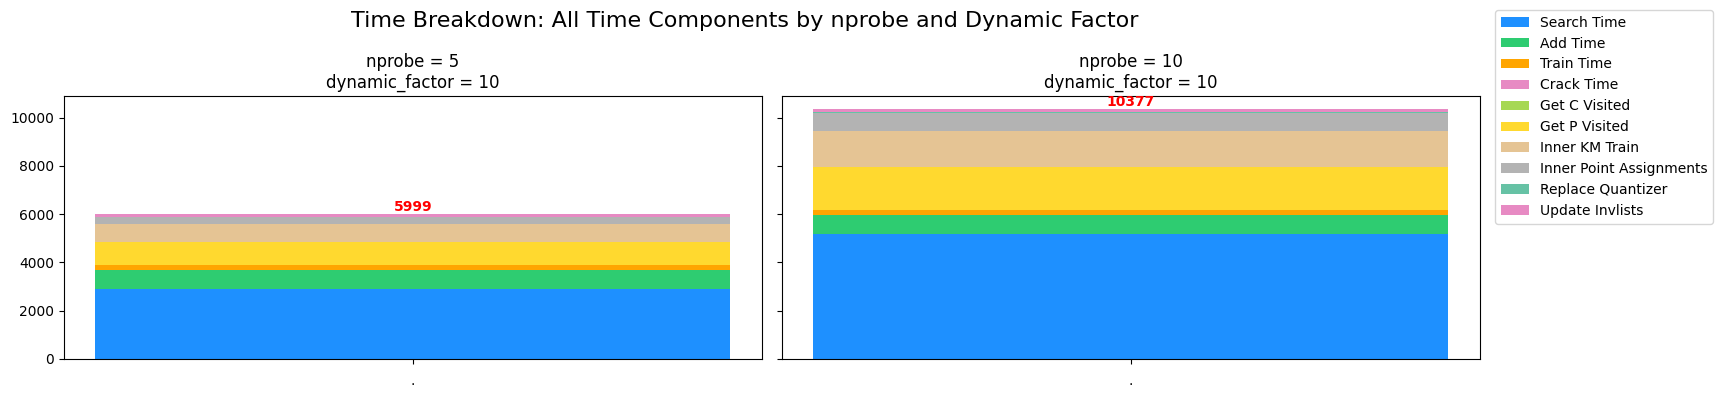

In [6]:
# Step 1: Prepare the data
grouped = cracked_median_per_Q_df.groupby(['nprobe', 'dynamic_nprobe_factor']).agg({
    'search_time_ms': 'sum',    # Total search time
    'add_time_ms': 'first',     # Add time
    'train_time_ms': 'first',   # Train time
    'crack_time_ms': 'sum',     # Crack time
    'get_c_visited_ms': 'sum',  # Get C visited time
    'get_p_visited_ms': 'sum',  # Get P visited time
    'inner_km_train_ms': 'sum', # Inner KM train time
    'inner_point_assignments_ms': 'sum',  # Inner point assignments time
    'replace_quantizer_ms': 'sum', # Replace quantizer time
    'update_invlists_ms': 'sum',  # Update invlists time
    'recall_1': 'mean',
    'recall_10': 'mean',
    'recall_100': 'mean',
}).reset_index()

# Create the figure with appropriate subplots
unique_nprobes = sorted(grouped['nprobe'].unique())
unique_dynamic_factors = sorted(grouped['dynamic_nprobe_factor'].unique())

# Create a grid of subplots
fig, axes = plt.subplots(
    len(unique_dynamic_factors), 
    len(unique_nprobes), 
    figsize=(15, 4*len(unique_dynamic_factors)), 
    sharey='row'
)

# If only one dynamic factor or one nprobe, ensure axes is 2D
if len(unique_dynamic_factors) == 1:
    axes = [axes]
if len(unique_nprobes) == 1:
    axes = [[ax] for ax in axes]

# Color palette
colors = sns.color_palette("Set2", n_colors=9)

# Plot for each combination of dynamic factor and nprobe
for i, dynamic_factor in enumerate(unique_dynamic_factors):
    for j, nprobe in enumerate(unique_nprobes):
        # Select subset of data
        subset = grouped[
            (grouped['nprobe'] == nprobe) & 
            (grouped['dynamic_nprobe_factor'] == dynamic_factor)
        ]
        
        print(subset[['dynamic_nprobe_factor','nprobe','search_time_ms']])
        
        
        # Skip if subset is empty
        if len(subset) == 0:
            continue
        
        # Prepare data for stacked bars
        search_times = subset['search_time_ms']
        add_times = subset['add_time_ms']
        train_times = subset['train_time_ms']
        crack_times = 0#subset['crack_time_ms']  # As in original script
        get_c_visited_times = subset['get_c_visited_ms']
        get_p_visited_times = subset['get_p_visited_ms']
        inner_km_train_times = subset['inner_km_train_ms']
        inner_point_assignments_times = subset['inner_point_assignments_ms']
        replace_quantizer_times = subset['replace_quantizer_ms']
        update_invlists_times = subset['update_invlists_ms']

        # Create stacked bar plot
        bar_width = 0.8  # Width of bars

        # Define a shared color palette for consistency
        shared_colors = {
            'Search Time': '#1E90FF',  # Dodger Blue
            'Add Time': '#2ECC71',     # Emerald Green
            'Train Time': '#FFA500',   # Orange
        }

        # Stack each time component
        current_bottom = 0
        current_bottom = axes[i][j].bar([0], search_times, bottom=current_bottom, label='Search Time', color=shared_colors['Search Time'], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], add_times, bottom=current_bottom, label='Add Time', color=shared_colors['Add Time'], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], train_times, bottom=current_bottom, label='Train Time', color=shared_colors['Train Time'], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], crack_times, bottom=current_bottom, label='Crack Time', color=colors[3], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], get_c_visited_times, bottom=current_bottom, label='Get C Visited', color=colors[4], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], get_p_visited_times, bottom=current_bottom, label='Get P Visited', color=colors[5], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], inner_km_train_times, bottom=current_bottom, label='Inner KM Train', color=colors[6], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], inner_point_assignments_times, bottom=current_bottom, label='Inner Point Assignments', color=colors[7], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], replace_quantizer_times, bottom=current_bottom, label='Replace Quantizer', color=colors[8], width=bar_width)[0].get_height() + current_bottom
        current_bottom = axes[i][j].bar([0], update_invlists_times, bottom=current_bottom, label='Update Invlists', color=colors[3], width=bar_width)[0].get_height() + current_bottom

        # Formatting
        axes[i][j].set_title(f'nprobe = {nprobe}\ndynamic_factor = {dynamic_factor}')
        axes[i][j].set_xlabel('.')
        axes[i][j].set_xticks([0])
        axes[i][j].set_xticklabels([''])
        
        # Add total time annotations
        total_time = (search_times + add_times + train_times + crack_times + get_c_visited_times + 
                      get_p_visited_times + inner_km_train_times + inner_point_assignments_times +
                      replace_quantizer_times + update_invlists_times)
        axes[i][j].text(
            0, 
            total_time, 
            f'{total_time.values[0]:.0f}', 
            ha='center', 
            va='bottom',
            fontweight='bold',
            color='red'
        )

# Overall formatting
fig.suptitle('Time Breakdown: All Time Components by nprobe and Dynamic Factor', fontsize=16)

# Single legend for all subplots
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

ivfflat


If batch size > 1, I can "crack" on all of the queries in the batch at the same time instead of one by one

In [17]:
# load
'''POSTER:
- SIFT1M_high_IVFFlat_1 : python run_benchmark.py --index_name IVFFlat --nthreads 16 --n_iter 0 10 --nprobe 5 10 20 40 60 --nruns 1 --dbname SIFT1M --nlist 16000 --store --limit_queries 10000 --skew high --seed 120 --runid 1
- SIFT1M_high_IVFFlat_2 : python run_benchmark.py --index_name IVFFlat --nthreads 127 --n_iter 0 10 --nprobe 5 10 20 40 60 --nruns 1 --dbname SIFT1M --nlist 16000 --store --limit_queries 10000 --skew high --seed 120 --runid 2

- TEXT2IMAGE_default_IVFFlat_1 : python run_benchmark.py --index_name IVFFlat --nthreads 127 --n_iter 0 10 --nprobe 5 10 20 40 60 --nruns 1 --dbname TEXT2IMAGE --nlist 16000 --store --limit_queries 10000 --skew default --seed 120 --runid 1
- TEXT2IMAGE_default_IVFFlat_2: python run_benchmark.py --index_name IVFFlat --nthreads 16 --n_iter 0 10 --nprobe 5 10 20 --nruns 1 --dbname TEXT2IMAGE --nlist 1000 --store --limit_queries 100000 --skew default --seed 120 --runid 2
- TEXT2IMAGE_default_IVFFlat_3: python run_benchmark.py --index_name IVFFlat --nthreads 16 --n_iter 0 10 --nprobe 5 10 20 --nruns 1 --dbname TEXT2IMAGE --nlist 1000 --store --limit_queries 100000 --skew default --seed 120 --runid 3 --batch_size 16
- TEXT2IMAGE_default_IVFFlat_4: python run_benchmark.py --index_name IVFFlat --nthreads 16 --n_iter 0 10 --nprobe 20 40 60 --nruns 1 --dbname TEXT2IMAGE --nlist 16000 --store --limit_queries 100000 --skew default --seed 120 --runid 4 --batch_size 16
- TEXT2IMAGE_default_IVFFlat_5: python run_benchmark.py --index_name IVFFlat --nthreads 16 --n_iter 0 10 --nprobe 20 40 60 --nruns 1 --dbname TEXT2IMAGE --nlist 16000 --store --limit_queries 100000 --skew default --seed 120 --runid 5 --batch_size 1
'''
df_new = pd.read_pickle("./results/TEXT2IMAGE_default_IVFFlat_1/result_df.pickle")
df_new.describe()
median_per_Q_df = df_new.dropna(axis=1).drop(columns=['run', 'seed'], axis=1).groupby(['dbname','skew','nthreads','max_pts','batch_size','index_name','nprobe','niter','qid']).median()
median_per_Q_df = median_per_Q_df.reset_index()
median_per_Q_df.nprobe.value_counts()

nprobe
5     50000
10    50000
20    50000
40    50000
60    50000
Name: count, dtype: int64

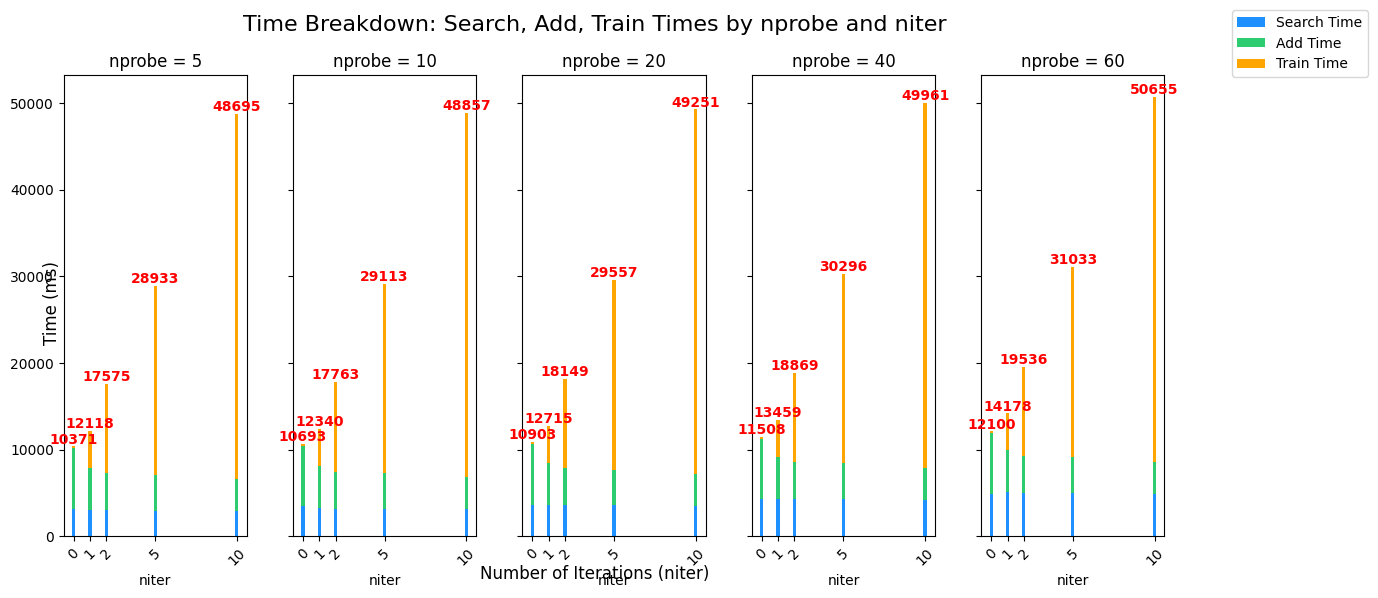

In [18]:
bar_width = 0.2
# Step 1: Prepare the data
grouped = median_per_Q_df.groupby(['nprobe', 'niter']).agg({
    'search_time_ms': 'sum',   # Total search time
    'add_time_ms': 'first',    # Add time
    'train_time_ms': 'first',   # Train time
    'recall_1': 'mean',
    'recall_10': 'mean',
    'recall_100': 'mean',
}).reset_index()

# Create the figure with appropriate subplots
unique_nprobes = sorted(grouped['nprobe'].unique())
fig, axes = plt.subplots(
    1, len(unique_nprobes), 
    figsize=(12, 6), 
    sharey=True
)


# Define a shared color palette for consistency
shared_colors = {
    'Search Time': '#1E90FF',  # Dodger Blue
    'Add Time': '#2ECC71',     # Emerald Green
    'Train Time': '#FFA500',   # Orange
}

# Ensure axes is always an array, even if there's only one subplot
if len(unique_nprobes) == 1:
    axes = [axes]

# Color palette
colors = ['#1E90FF', '#2ECC71', '#FFA500']  # Dodger Blue, Emerald Green, Orange

# Plot for each nprobe value
for i, nprobe in enumerate(unique_nprobes):
    subset = grouped[grouped['nprobe'] == nprobe]
    
    # Prepare data for stacked bar
    search_times = subset['search_time_ms']
    add_times = subset['add_time_ms']
    train_times = subset['train_time_ms']
    
    # Create stacked bar plot
    # Increased bar width from default 0.8 to a larger value
    
    axes[i].bar(subset['niter'], search_times, label='Search Time', color=shared_colors['Search Time'], width=bar_width)
    axes[i].bar(subset['niter'], add_times, bottom=search_times, label='Add Time', color=shared_colors['Add Time'], width=bar_width)
    axes[i].bar(subset['niter'], train_times, bottom=search_times+add_times, label='Train Time', color=shared_colors['Train Time'], width=bar_width) 

    # Formatting
    axes[i].set_title(f'nprobe = {nprobe}')
    axes[i].set_xlabel('niter')
    axes[i].set_xticks(subset['niter'])
    axes[i].set_xticklabels(subset['niter'], rotation=45)
    
    # Add total time annotations
    for j, (search, add, train) in enumerate(zip(search_times, add_times, train_times)):
        total = search + add + train
        axes[i].text(
            subset['niter'].iloc[j], 
            total, 
            f'{total:.0f}', 
            ha='center', 
            va='bottom',
            fontweight='bold',
            color='red'
        )

# Overall formatting
fig.suptitle('Time Breakdown: Search, Add, Train Times by nprobe and niter', fontsize=16)
fig.text(0.5, 0.04, 'Number of Iterations (niter)', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Time (ms)', va='center', rotation='vertical', fontsize=12)

# Single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

In [10]:
grouped_ivf = median_per_Q_df.groupby(['nprobe', 'niter']).agg({
    'search_time_ms': 'sum',   # Total search time
    'add_time_ms': 'first',    # Add time
    'train_time_ms': 'first',   # Train time
    'recall_1': 'mean',
    'recall_10': 'mean',
    'recall_100': 'mean',
}).reset_index()

grouped_cracked = cracked_median_per_Q_df.groupby(['nprobe', 'dynamic_nprobe_factor', 'dynamic_nprobe','niter']).agg({
    'search_time_ms': 'median',    # Total search time
    'add_time_ms': 'sum',     # Add time
    'train_time_ms': 'sum',   # Train time
    'crack_time_ms': 'sum',     # Crack time
    'get_c_visited_ms': 'sum',  # Get C visited time
    'get_p_visited_ms': 'sum',  # Get P visited time
    'inner_km_train_ms': 'sum', # Inner KM train time
    'inner_point_assignments_ms': 'sum',  # Inner point assignments time
    'replace_quantizer_ms': 'sum', # Replace quantizer time
    'update_invlists_ms': 'sum',  # Update invlists time
    'recall_1': 'mean',
    'recall_10': 'mean',
    'recall_100': 'mean',
}).reset_index()

# grouped[['nprobe','niter','dynamic_nprobe_factor','dynamic_nprobe','search_time_ms','recall_1','recall_10','recall_100']]
grouped_cracked['total_crack'] = grouped_cracked['train_time_ms'] + grouped_cracked['get_c_visited_ms'] + grouped_cracked['get_p_visited_ms'] + grouped_cracked["inner_km_train_ms"] + grouped_cracked["inner_point_assignments_ms"] + grouped_cracked["replace_quantizer_ms"] + grouped_cracked["update_invlists_ms"]
grouped_cracked[['nprobe','niter','search_time_ms','crack_time_ms', 'add_time_ms', 'total_crack','recall_1','recall_10','recall_100']]


,nprobe,niter,search_time_ms,crack_time_ms,add_time_ms,total_crack,recall_1,recall_10,recall_100
0,5,0,0.253389,453.232123,9.969628e+07,1.038488e+06,0.5243,0.49150,0.390804
1,10,0,0.285234,529.503076,9.969628e+07,1.038561e+06,0.6482,0.61569,0.517690
2,20,0,0.311464,699.261022,9.969628e+07,1.038727e+06,0.7542,0.72848,0.642822
3,40,0,0.381909,1112.684514,9.969628e+07,1.039140e+06,0.8420,0.82350,0.755865
4,60,0,0.460153,1475.080790,9.969628e+07,1.039500e+06,0.8846,0.86785,0.813059


In [9]:
grouped_ivf

,nprobe,niter,search_time_ms,add_time_ms,train_time_ms,recall_1,recall_10,recall_100
0,5,0,3130.446089,7011.300716,229.055377,0.4574,0.41291,0.313495
1,5,1,3003.716470,4851.218215,4262.996998,0.5490,0.49457,0.365381
2,5,2,2989.768215,4276.752904,10308.905456,0.5843,0.52114,0.381888
3,5,5,2950.007968,4133.874203,21849.225649,0.6039,0.54368,0.397084
4,5,10,2972.472756,3691.724879,42030.979709,0.6144,0.55450,0.404013
5,10,0,3452.639195,7011.300716,229.055377,0.5778,0.53270,0.430130
6,10,1,3225.683127,4851.218215,4262.996998,0.6730,0.62317,0.497093
7,10,2,3177.558068,4276.752904,10308.905456,0.6990,0.64607,0.515492
8,10,5,3129.643067,4133.874203,21849.225649,0.7198,0.66835,0.531580
9,10,10,3134.045846,3691.724879,42030.979709,0.7324,0.67752,0.538510


# Skew OOD

In [13]:
DATASET = "text2image-1M-OOD"
#NOTE: limited to first 10ak queries from dataset
xb, xq, gt, metric = load_OOD_text2image(limit_queries=None) # 
xt = None
nb, d = xb.shape
nlist = 1000

Loading OOD-Text2Image...

Symlink created: data -> /pub/scratch/vmageirakos/datasets/big-ann-benchmarks/
Symlink data removed.
dataset shape:
xb.shape=(1000000, 200)
xq.shape=(100000, 200)
gt.shape=(100000, 100)
metric='angular'


In [16]:
xq.shape

(100000, 200)

In [18]:
from vasili_helpers import *

In [32]:
nlist = 1

1000

This is an approximation: 
- Basically plot the skewness in the nprobe nearest centroids for all 100k queries
- Then plot dynamic nprobe for the first 100 queries. Because I stop cracking after 100 in the poster example and I have dynamic nprobe

In [57]:
search_nprobe = 60
dynamic_nprobe_factor = 10

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 200D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
- Total number of unique centroids visited: 16000
- % of total centroids: 100.0 %


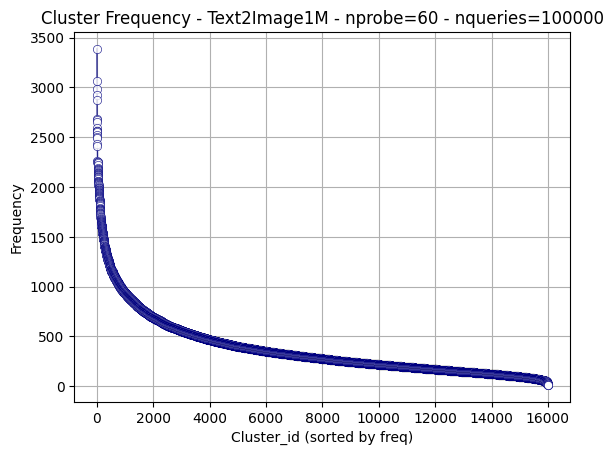

In [58]:
quantizer = faiss.IndexFlatL2(d)
ood_index = faiss.IndexIVFFlat(quantizer, d, 16000, faiss.METRIC_INNER_PRODUCT)  # Use INNER_PRODUCT for angular
# ood_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)  # Use INNER_PRODUCT for angular
# trained_index.cp.seed = int(time.time())
ood_index.cp.niter= 10
ood_index.cp.nredo = 1
ood_index.verbose=True
ood_index.cp.seed = 121

ood_index.train(xb)
ood_index.add(xb)

_ = get_centroid_ids_per_query(
        index=ood_index, # D(x)
        # combined_index, # D(x), Q(x) 
        queries=xq,
        nprobe=search_nprobe, 
        plot_hist=True,
        sorted_order=True,
        dataset_name = "Text2Image1M"
    )

- Total number of unique centroids visited: 14366
- % of total centroids: 90.0 %


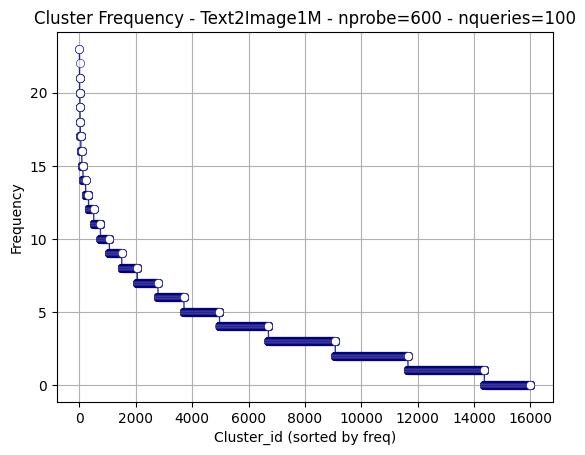

In [68]:
_ = get_centroid_ids_per_query(
        index=ood_index, # D(x)
        # combined_index, # D(x), Q(x) 
        queries=xq[:100,:],
        nprobe=search_nprobe * dynamic_nprobe_factor,
        plot_hist=True,
        sorted_order=True,
        dataset_name = "Text2Image1M"
    )

TODO:
- graph like above, but for SIFT1M 16k and in the same graph for nprobe=60 do : default, medium, high skewness to show I can control it

# Why Train & Why more Centroids

In [5]:
from vasili_helpers import *

In [ ]:
# ann benchmarks sift1m
xb, xq, xt, gt, metric = load_sift1M(f"/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean")

Loading sift1M...

dataset shape:
xb.shape=(1000000, 128)
gt.shape=(10000, 100)
xq.shape=(10000, 128)


done


run_benchmarks uses this version of SIFT1M which is why I had ever so slightly different results from that vs this notebook and I got confused.

the poster is using the above load_sift1m version of the dataset

In [10]:
# big-ann sift1m

dbsize = int("SIFT1M"[4:-1])

# dataset_dir = '/mnt/scratch/wenqi/Faiss_experiments/bigann'
# CHEF NOTE: reading from bigann benchmark SIFT1M, SIFT10M, SIFT100M, SIFT1B (or 1000M not sure)
dataset_dir = "/pub/scratch/vmageirakos/datasets/bigann"
# CHEF when I download SIFT1B use this:
xb = mmap_bvecs(os.path.join(dataset_dir, 'bigann_base.bvecs'))
xq = mmap_bvecs(os.path.join(dataset_dir, 'bigann_query.bvecs'))
gt = ivecs_read(os.path.join(dataset_dir, 'gnd/idx_%dM.ivecs' % dbsize))

# trim xb to correct size
xb = xb[:dbsize * 1000 * 1000]

# Wenqi: load xq to main memory and reshape
xq = xq.astype("float32").copy()
xq = np.array(xq, dtype=np.float32)
gt = np.array(gt, dtype=np.int32)
metric = 'euclidean'

- Total number of unique centroids visited: 1000
- % of total centroids: 100.0 %


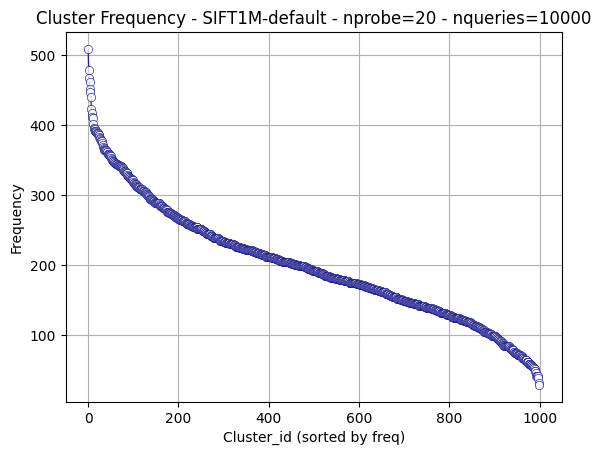

In [287]:
# for sift1m (make sure index has been built)
_ = get_centroid_ids_per_query(
        index=index_1000, # D(x)
        # combined_index, # D(x), Q(x) 
        queries=xq,
        nprobe=20,
        plot_hist=True,
        sorted_order=True,
        dataset_name = "SIFT1M-default"
    )

In [8]:
nthreads=128
faiss.omp_set_num_threads(nthreads)

In [ ]:
nlist = 1000
index_1000, train_time_1000, add_time_1000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000, train_time_5000, add_time_5000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000, train_time_16000, add_time_16000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

Kmeans... nlist=1000 km_n_iter=10 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 6450.922413998342 ms | Add Time = 1566.3435539972852 ms <---
Kmeans... nlist=5000 km_n_iter=10 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D


In [54]:
nlist = 1000
index_1000_untrained, train_time_1000_untrained, add_time_1000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000_untrained, train_time_5000_untrained, add_time_5000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000_untrained, train_time_16000_untrained, add_time_16000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

Kmeans... nlist=1000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 219.33854300004896 ms | Add Time = 2019.679482000356 ms <---
Kmeans... nlist=5000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 148.82872399903135 ms | Add Time = 7184.167430998059 ms <---
Kmeans... nlist=16000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 141.08148900049855 ms | Add Time = 19325

In [55]:
nthreads=32
faiss.omp_set_num_threads(nthreads)

In [9]:
# nprobe = 20
index_1000.nprobe = 19
index_5000.nprobe = 50
index_16000.nprobe = 100
nq, d = xq.shape
batch_size = nthreads
topK = 100
I1 = np.empty((nq, topK), dtype="int32")
D1 = np.empty((nq, topK), dtype="float32")

I2 = np.empty((nq, topK), dtype="int32")
D2 = np.empty((nq, topK), dtype="float32")

I3 = np.empty((nq, topK), dtype="int32")
D3 = np.empty((nq, topK), dtype="float32")

timings_1000,timings_5000,timings_16000 = [], [], []
i0 = 0
while i0 < nq:
    t_batch_start = time.perf_counter()

    if i0 + batch_size < nq:
        i1 = i0 + batch_size
    else:
        i1 = nq

    Di, Ii = index_1000.search(xq[i0:i1], k=topK)
    I1[i0:i1] = Ii
    D1[i0:i1] = Di
    t_batch_end = time.perf_counter()
    timings_1000.append((t_batch_end-t_batch_start))

    #### 5000
    t_batch_start = time.perf_counter()
    if i0 + batch_size < nq:
        i1 = i0 + batch_size
    else:
        i1 = nq

    Di, Ii = index_5000.search(xq[i0:i1], k=topK)
    I2[i0:i1] = Ii
    D2[i0:i1] = Di
    t_batch_end = time.perf_counter()
    timings_5000.append((t_batch_end-t_batch_start))

    ## 16k
    t_batch_start = time.perf_counter()
    if i0 + batch_size < nq:
        i1 = i0 + batch_size
    else:
        i1 = nq

    Di, Ii = index_16000.search(xq[i0:i1], k=topK)
    I3[i0:i1] = Ii
    D3[i0:i1] = Di
    t_batch_end = time.perf_counter()
    
    timings_16000.append((t_batch_end-t_batch_start))

    i0 = i1 # prepare for next iter
final_recall_1000 = compute_recall(I1, gt, k=100)
final_recall_5000 = compute_recall(I2, gt, k=100)
final_recall_16000 = compute_recall(I3, gt, k=100)
print(final_recall_1000, final_recall_5000, final_recall_16000)

0.905942 0.902642 0.903058


In [10]:
final_recall_1000 = compute_recall(I1, gt, k=100)
final_recall_5000 = compute_recall(I2, gt, k=100)
final_recall_16000 = compute_recall(I3, gt, k=100)
print(final_recall_1000, final_recall_5000, final_recall_16000)

0.905942 0.902642 0.903058


/tmp/ipykernel_110028/1036336883.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_timings, labels=labels)


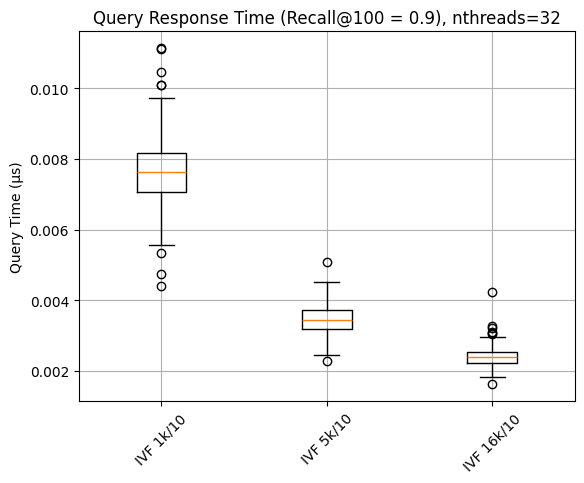

In [89]:
# # timings_1000
# labels, all_timings=[],[]
# all_timings.extend([timings_1000, timings_5000, timings_16000])
# labels.extend(['IVF 1k/10', 'IVF 5k/10', 'IVF 16k/10'])
# plt.boxplot(all_timings, labels=labels)
# plt.title(f'Query Response Time (Recall@100 = 0.9), {nthreads=}')
# plt.xticks(rotation=45)
# plt.ylabel('Query Time (µs)')
# plt.grid(True)

In [11]:
# nprobe = 20
index_1000_untrained.nprobe = 24
index_5000_untrained.nprobe = 64
index_16000_untrained.nprobe = 140

nq, d = xq.shape
batch_size = nthreads
topK = 100
I1 = np.empty((nq, topK), dtype="int32")
D1 = np.empty((nq, topK), dtype="float32")

I2 = np.empty((nq, topK), dtype="int32")
D2 = np.empty((nq, topK), dtype="float32")

I3 = np.empty((nq, topK), dtype="int32")
D3 = np.empty((nq, topK), dtype="float32")

timings_1000_untrained,timings_5000_untrained,timings_16000_untrained = [], [], []
i0 = 0
while i0 < nq:
    t_batch_start = time.perf_counter()

    if i0 + batch_size < nq:
        i1 = i0 + batch_size
    else:
        i1 = nq

    Di, Ii = index_1000_untrained.search(xq[i0:i1], k=topK)
    I1[i0:i1] = Ii
    D1[i0:i1] = Di
    t_batch_end = time.perf_counter()
    timings_1000_untrained.append((t_batch_end-t_batch_start))

    #### 5000
    t_batch_start = time.perf_counter()
    if i0 + batch_size < nq:
        i1 = i0 + batch_size
    else:
        i1 = nq

    Di, Ii = index_5000_untrained.search(xq[i0:i1], k=topK)
    I2[i0:i1] = Ii
    D2[i0:i1] = Di
    t_batch_end = time.perf_counter()
    timings_5000_untrained.append((t_batch_end-t_batch_start))

    ## 16k
    t_batch_start = time.perf_counter()
    if i0 + batch_size < nq:
        i1 = i0 + batch_size
    else:
        i1 = nq

    Di, Ii = index_16000_untrained.search(xq[i0:i1], k=topK)
    I3[i0:i1] = Ii
    D3[i0:i1] = Di
    t_batch_end = time.perf_counter()
    
    timings_16000_untrained.append((t_batch_end-t_batch_start))

    i0 = i1 # prepare for next iter
    
final_recall_1000 = compute_recall(I1, gt, k=100)
final_recall_5000 = compute_recall(I2, gt, k=100)
final_recall_16000 = compute_recall(I3, gt, k=100)
print(final_recall_1000, final_recall_5000, final_recall_16000)

0.908372 0.903507 0.905675


/tmp/ipykernel_41438/2728262061.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_timings_ms, labels=labels)


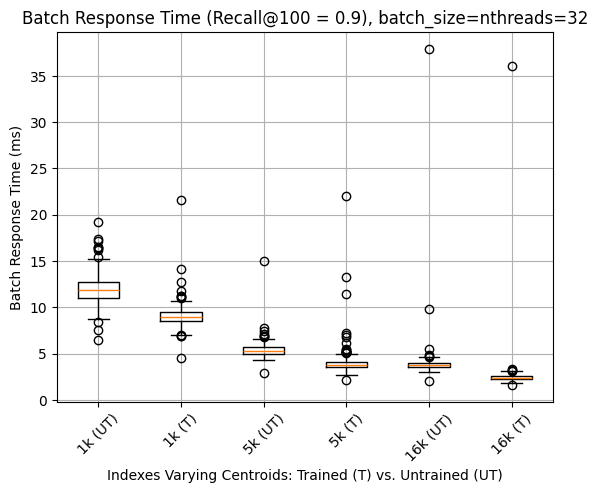

In [12]:
# timings_1000
labels, all_timings=[],[]
all_timings.extend([timings_1000_untrained, timings_1000, timings_5000_untrained,timings_5000, timings_16000_untrained,timings_16000])
# labels.extend(['1k cent','1k cent & trained',' 5k', 'IVF 5k trained', 'IVF 16k', 'IVF 16k trained'])
labels = [
    '1k (UT)' ,   # UT = Untrained
    '1k (T)',    # T = Trained
    '5k (UT)',
    '5k (T)',
    '16k (UT)',
    '16k (T)'
]
all_timings_ms = [[1000 * value for value in inner_list] for inner_list in all_timings]

plt.boxplot(all_timings_ms, labels=labels)
plt.title(f'Batch Response Time (Recall@100 = 0.9), batch_size={nthreads=}')
plt.xticks(rotation=45)
plt.ylabel('Batch Response Time (ms)')
plt.xlabel('Indexes Varying Centroids: Trained (T) vs. Untrained (UT)')
plt.grid(True)

Get QPS-Recall

In [13]:
nthreads=32
faiss.omp_set_num_threads(nthreads)

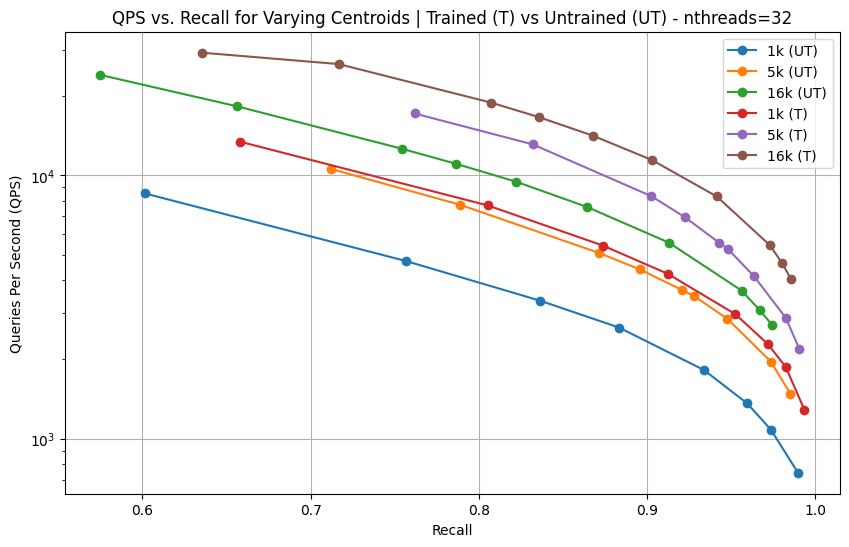

In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt

batch_size = nthreads
topK = 100
nq, d = xq.shape

# Define independent nprobe values for each index
nprobe_values_1000 = [5, 10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [20, 30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [20, 30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (UT)": (index_1000_untrained, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (UT)": (index_5000_untrained, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (UT)": (index_16000_untrained, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "1k (T)": (index_1000, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (T)": (index_5000, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (T)": (index_16000, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results = {key: [] for key in indexes.keys()}
batch_num = 0
# limit_crack = limit_refine = 100
# Iterate over indexes and their independent nprobe values
for name, (index, nprobe_values, I, D) in indexes.items():
    for nprobe in nprobe_values:
        index.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        nq, topK = xq.shape[0], 100
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            # if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
            #     CRACK = REFINE = True
            # else:
            #     CRACK = REFINE = False

            Di, Ii = index.search(xq[i0:i1], k=topK)
            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(t_batch_end - t_batch_start)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)
        qps = nq / total_time
        recall = compute_recall(I, gt, k=topK)
        results[name].append((qps, recall))

# Plot results (Recall vs QPS)
plt.figure(figsize=(10, 6))
for name, data in results.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()


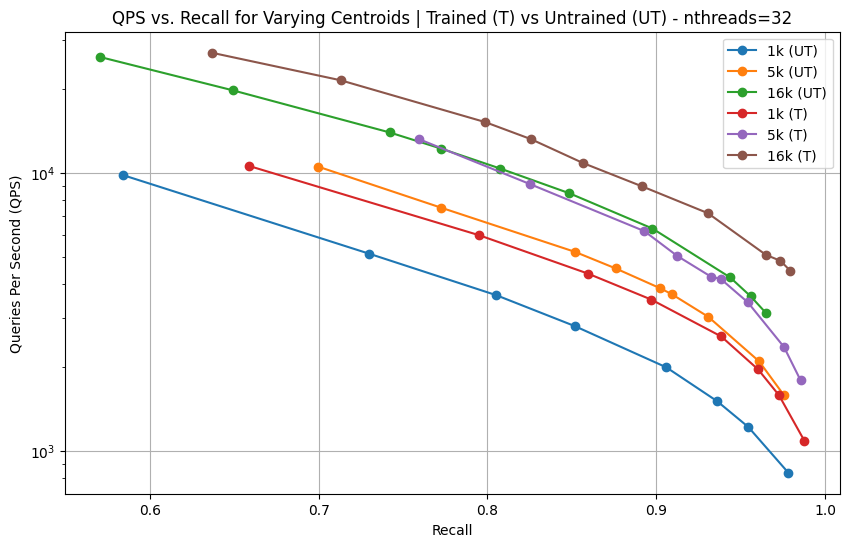

In [56]:
import numpy as np
import time
import matplotlib.pyplot as plt

batch_size = nthreads
topK = 100
nq, d = xq.shape
# I1 = np.empty((nq, topK), dtype="int32")
# D1 = np.empty((nq, topK), dtype="float32")
# I2 = np.empty((nq, topK), dtype="int32")
# D2 = np.empty((nq, topK), dtype="float32")
# I3 = np.empty((nq, topK), dtype="int32")
# D3 = np.empty((nq, topK), dtype="float32")

# Define independent nprobe values for each index
nprobe_values_1000 = [5, 10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [20, 30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [20, 30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (UT)": (index_1000_untrained, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (UT)": (index_5000_untrained, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (UT)": (index_16000_untrained, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "1k (T)": (index_1000, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (T)": (index_5000, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (T)": (index_16000, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results = {key: [] for key in indexes.keys()}
batch_num = 0
limit_crack = limit_refine = 100
# Iterate over indexes and their independent nprobe values
for name, (index, nprobe_values, I, D) in indexes.items():
    for nprobe in nprobe_values:
        index.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        nq, topK = xq.shape[0], 100
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
                CRACK = REFINE = True
            else:
                CRACK = REFINE = False

            Di, Ii = index.search(xq[i0:i1], k=topK)
            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(t_batch_end - t_batch_start)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)  # Total time for all batches
        total_batches = len(timings)  # Number of batches processed
        assert total_batches * batch_size >= nq, "Total batches multiplied by batch_size should cover all queries."
        qps = (batch_size * total_batches) / total_time  # QPS based on batch size and timings

        recall = compute_recall(I, gt, k=topK)
        results[name].append((qps, recall))

# Plot results (Recall vs QPS)
plt.figure(figsize=(10, 6))
for name, data in results.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

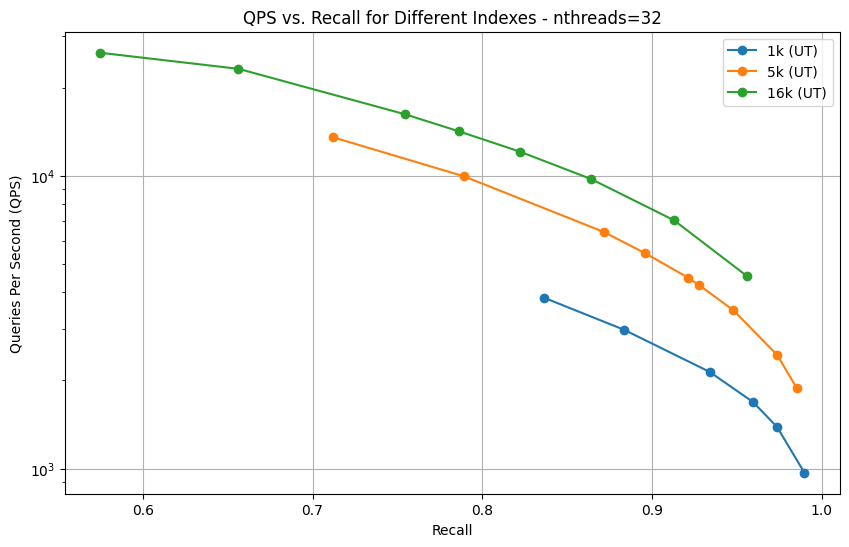

In [ ]:
# Plot QPS vs. Recall
# Plot Recall vs. QPS (Swapped Axes)
plt.figure(figsize=(10, 6))
for name, data in results.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]  # Swap recall and QPS
    plt.plot(recall, qps, marker='o', label=name)

# Customize plot
# plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

Better plot:

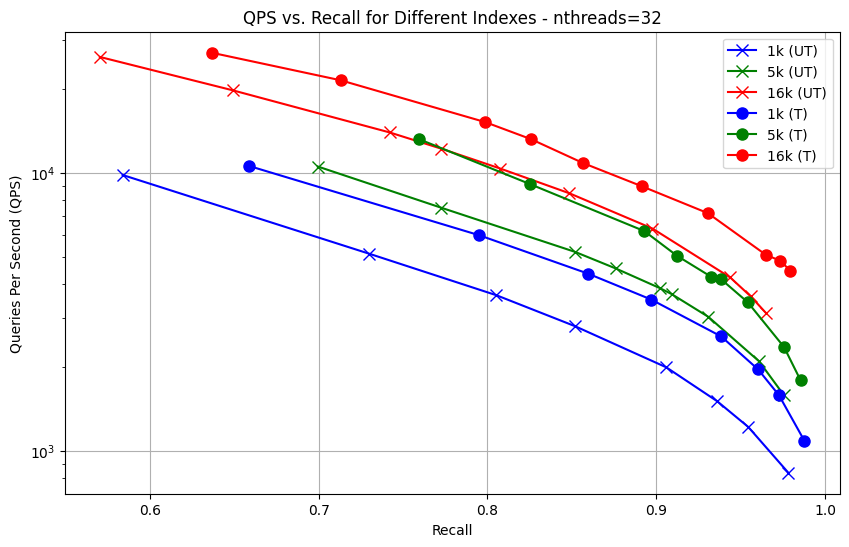

In [57]:
# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "x"  # Cross for untrained
}

# Plot results
plt.figure(figsize=(10, 6))

for name, data in results.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)" or "(UT)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle='-', markersize=8)

plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

1k untrained only. Used to double check we get the same with run_benchmarks.py


Kmeans... nlist=1000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 190.78269000237924 ms | Add Time = 1317.1173269984138 ms <---
nprobe=5 batch_size=32
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
nprobe=10 batch_size=32
nprobe=15 batch_size=32
nprobe=20 batch_size=32
nprobe=30 batch_size=32


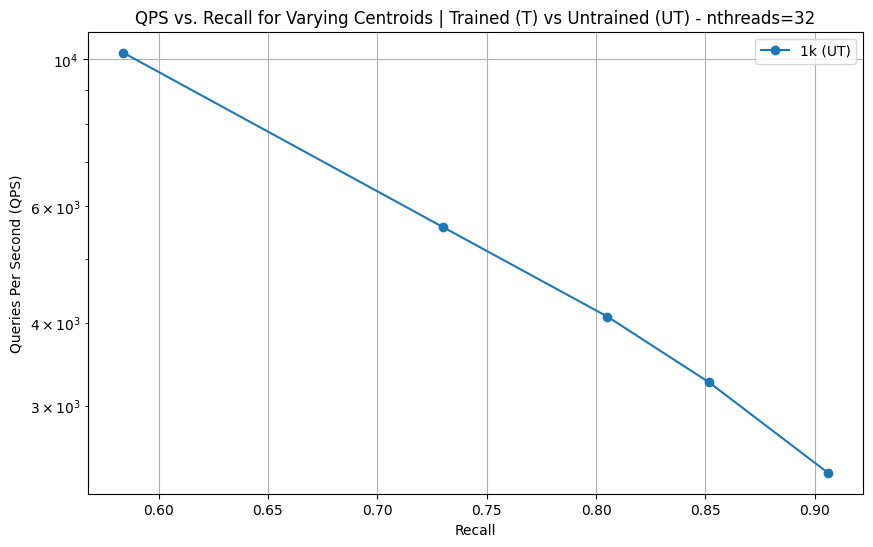

{'1k (UT)': [(10238.331260413823, 0.583857),
  (5583.568196504696, 0.729942),
  (4088.031730861395, 0.805215),
  (3253.6215628099208, 0.851606),
  (2375.4526838343418, 0.905965)]}

In [44]:
import numpy as np
import time
import matplotlib.pyplot as plt


nlist = 1000
index_1000_untrained, train_time_1000_untrained, add_time_1000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

batch_size = nthreads
topK = 100
nq, d = xq.shape
# I1 = np.empty((nq, topK), dtype="int32")
# D1 = np.empty((nq, topK), dtype="float32")
# I2 = np.empty((nq, topK), dtype="int32")
# D2 = np.empty((nq, topK), dtype="float32")
# I3 = np.empty((nq, topK), dtype="int32")
# D3 = np.empty((nq, topK), dtype="float32")

# Define independent nprobe values for each index
nprobe_values_1000 = [5, 10, 15, 20, 30]#, 40, 50, 75]
# nprobe_values_5000 = [20, 30, 50, 60, 75, 80, 100, 150, 200]
# nprobe_values_16000 = [20, 30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (UT)": (index_1000_untrained, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    # "5k (UT)": (index_5000_untrained, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    # "16k (UT)": (index_16000_untrained, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    # "1k (T)": (index_1000, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    # "5k (T)": (index_5000, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    # "16k (T)": (index_16000, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results_1k = {key: [] for key in indexes.keys()}
batch_num = 0
limit_crack = limit_refine = 100
# Iterate over indexes and their independent nprobe values
for name, (index, nprobe_values, I, D) in indexes.items():
    for nprobe in nprobe_values:
        print(f"{nprobe=} {batch_size=}")
        index.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        nq, topK = xq.shape[0], 100
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            # if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
            #     CRACK = REFINE = True
            # else:
                # CRACK = REFINE = False

            Di, Ii = index.search(xq[i0:i1], k=topK)
            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(t_batch_end - t_batch_start)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)  # Total time for all batches
        total_batches = len(timings)  # Number of batches processed
        assert total_batches * batch_size >= nq, "Total batches multiplied by batch_size should cover all queries."
        qps = (batch_size * total_batches) / total_time  # QPS based on batch size and timings

        recall = compute_recall(I, gt, k=topK)
        results_1k[name].append((qps, recall))

# Plot results (Recall vs QPS)
plt.figure(figsize=(10, 6))
for name, data in results_1k.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
results_1k

TODO:
- Cracking Index ^^
- Skewed Dataset ( ^^ )
- ^^ for .add() and .train()

For this plot is it very important to understand exactly what part of Cracking we're plotting.
Since the result of a query is available BEFORE the crack/reorg/refine finishes and because for the other indexes we are NOT including the build time in the SUM(total timings) -----> here for cracking we only count search time.
For other we also only count search time.


To compare the total cummulative time, see the cummulative time plots...

In [16]:
from vasili_helpers import *

In [58]:
nthreads=32
faiss.omp_set_num_threads(nthreads)

In [59]:
from collections import defaultdict

`python run_benchmark.py --index_name CrackRefineIVFFlat --nthreads 32 --batch_size 32 --n_iter 0 --nprobe 5 10 15 20 30 --nruns 1 --dbname SIFT1M --nlist 1000  --seed 42  --limit_refine 30 --refine_nprobe 100 --init_cents`

In [1]:
# Cracking:
nlist = 1000
index_1000_crack, train_time_1000_crack, add_time_1000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000_crack, train_time_5000_crack, add_time_5000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000_crack, train_time_16000_crack, add_time_16000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

########################################

batch_size = nthreads
topK = 100
nq, d = xq.shape

# Define independent nprobe values for each index
nprobe_values_1000 = [5, 10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [20, 30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [20, 30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (Crack)": (index_1000_crack, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (Crack)": (index_5000_crack, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (Crack)": (index_16000_crack, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results_crack = {key: [] for key in indexes.keys()}

# Iterate over indexes and their independent nprobe values

build_times_crack = defaultdict(list)

for name, (index, nprobe_values, I, D) in indexes.items():

    if "1k" in name:
        refine_nprobe = 100
        limit_crack = limit_refine = 30
    elif "5k" in name:
        refine_nprobe = 500
        limit_crack = limit_refine = 50
    elif "16k" in name:
        refine_nprobe = 1000
        limit_crack = limit_refine = 100

    for nprobe in nprobe_values:
        # CHEF SOS NOTE: INIT CENTROIDS
        index_to_crack = faiss.clone_index(index) # reset to start each time
        _ = init_centroids_after_assignments(index_to_crack, metric=metric) # init cents

        index_to_crack.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        batch_num = 0
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            # if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
            if batch_num <= limit_crack and batch_num <= limit_refine: 
                CRACK = REFINE = True
            else:
                CRACK = REFINE = False
            # dynamic_nprobe = min(nprobe, index.nlist)
            index_to_crack, Di, Ii, detailed_timings, d_nprobe = search_crack_refine_single(
                index_to_crack,
                xq[i0:i1],
                nprobe=nprobe,
                k=topK,
                refine_niter=1,
                CRACK=CRACK,
                REFINE=REFINE,
                # refine_nprobe_factor=None,
                metric=metric,
                refine_nprobe=refine_nprobe,
            )

            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(detailed_timings["search"][0])
            
            # total time of build from individual operations
            total_time = 0
            for key in ["get_c_visited", "get_p_visited", "crack", "update_invlists", "replace_quantizer", "inner_point_assignments", "inner_km_train"]:
                # Safely check if the list is empty before accessing the first element
                timings_list = detailed_timings.get(key, [])
                if timings_list:
                    total_time += timings_list[0]  # Add the first element of the list
                else:
                    total_time += 0  # Default to 0 if the list is empty or not found
                
            build_times_crack[(name, nprobe)].append(total_time)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)  # Total time for all batches
        total_batches = len(timings)  # Number of batches processed
        assert total_batches * batch_size >= nq, "Total batches multiplied by batch_size should cover all queries."
        qps = (batch_size * total_batches) / total_time  # QPS based on batch size and timings

        recall = compute_recall(I, gt, k=topK)
        results_crack[name].append((qps, recall))

# results.extend(results_crack)
# Plot results (Recall vs QPS)
comb_results = results | results_crack
plt.figure(figsize=(10, 6))
for name, data in results_crack.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "x", # Cross for untrained
    "(Crack)": "^",
}

linestyle_styles = {
    "(T)": "-",      # Solid line for trained
    "(UT)": "-",    # Dashed line for untrained
    "(Crack)": "-.", # Dash-dot line for Crack
}


# Plot results
plt.figure(figsize=(10, 6))
comb_results = results | results_crack

for name, data in comb_results.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)" or "(UT)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    linestyle = linestyle_styles[status]
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle=linestyle, markersize=8)

plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'train_ivfflat' is not defined

In [61]:
results

{'1k (UT)': [(9831.154707879536, 0.583857),
  (5122.879714393931, 0.729942),
  (3634.3205357203556, 0.805215),
  (2815.7285875891016, 0.851606),
  (1999.7625214118675, 0.905965),
  (1511.898626797879, 0.936005),
  (1220.8587172022021, 0.954495),
  (835.5897550644581, 0.978255)],
 '5k (UT)': [(10544.46545300624, 0.699505),
  (7507.18283396332, 0.772331),
  (5202.125449846532, 0.851859),
  (4534.598169851913, 0.875996),
  (3852.521585771157, 0.902184),
  (3667.9011973749607, 0.909104),
  (3038.772169817718, 0.930823),
  (2102.06247484883, 0.960926),
  (1584.2640142254897, 0.975757)],
 '16k (UT)': [(26126.241878311506, 0.570375),
  (19805.86327008888, 0.649303),
  (13986.616852487992, 0.742017),
  (12222.659798406918, 0.772697),
  (10366.35455641716, 0.80765),
  (8447.83874378598, 0.848587),
  (6309.823414859864, 0.897775),
  (4209.34304945776, 0.943799),
  (3598.110624488086, 0.955988),
  (3146.100753600773, 0.964793)],
 '1k (T)': [(10587.294419237702, 0.658902),
  (5971.6834078509, 0.79

In [62]:
results_crack

{'1k (Crack)': [(16539.564861021252, 0.623429),
  (12857.700215317958, 0.764568),
  (7683.269123584139, 0.833912),
  (7680.051861257126, 0.875276),
  (3309.5593645659396, 0.922796),
  (1742.2305691103722, 0.948284),
  (1835.8290461518723, 0.963541),
  (1146.1817330832212, 0.982674)],
 '5k (Crack)': [(15301.35083155185, 0.742885),
  (12543.092538932928, 0.81108),
  (8646.723701581745, 0.881459),
  (5712.603657355547, 0.902505),
  (5713.376111509533, 0.924509),
  (5284.762967964113, 0.930224),
  (4165.169673619266, 0.947965),
  (2984.1608548642653, 0.971471),
  (1983.6308159551327, 0.982655)],
 '16k (Crack)': [(23890.032222492013, 0.623869),
  (18598.66294472286, 0.700312),
  (14641.595436709758, 0.786837),
  (13007.109317362407, 0.814787),
  (15316.861751639575, 0.846034),
  (8792.818428299162, 0.882074),
  (7571.919813829744, 0.923746),
  (6076.568683373455, 0.960515),
  (3697.841022078579, 0.970046),
  (3505.469032126618, 0.976539)]}

Show that build time across nprobes is the same for some ncentroids because we fix limit crack & refine nprobe 

In [40]:
# crack times during serach [ need to all add the .add() time at the start... ]
total_build_time = {}
for k,v in build_times_crack.items():
    total_build_time[k] = sum(v)
    print(k, total_build_time[k])

('1k (Crack)', 5) 2.6803161490825005
('1k (Crack)', 10) 2.735471599000448
('1k (Crack)', 15) 2.782566559013503
('1k (Crack)', 20) 2.795495095982915
('1k (Crack)', 30) 2.788979695957096
('1k (Crack)', 40) 2.7961820489435922
('1k (Crack)', 50) 2.784740884992061
('1k (Crack)', 75) 2.7340796619319008
('5k (Crack)', 20) 10.097976889112033
('5k (Crack)', 30) 10.03278349696484
('5k (Crack)', 50) 10.131403140083421
('5k (Crack)', 60) 10.453273513994645
('5k (Crack)', 75) 10.528942158009158
('5k (Crack)', 80) 10.366592862010293
('5k (Crack)', 100) 10.468344994944346
('5k (Crack)', 150) 10.247346013886272
('5k (Crack)', 200) 10.292617149083526
('16k (Crack)', 20) 22.085895878983138
('16k (Crack)', 30) 21.19139382202411
('16k (Crack)', 50) 21.849626433089725
('16k (Crack)', 60) 21.717351334104023
('16k (Crack)', 75) 22.066586373199243
('16k (Crack)', 100) 21.614860746958584
('16k (Crack)', 150) 21.48654913606879
('16k (Crack)', 250) 21.532209277836955
('16k (Crack)', 300) 21.622809673041047
('16k

In [44]:
a = []
for k,v in total_build_time.items():
    a.append(v)
(30+sum(a))/60

6.021147373571269

Better looking plot ( clearer )

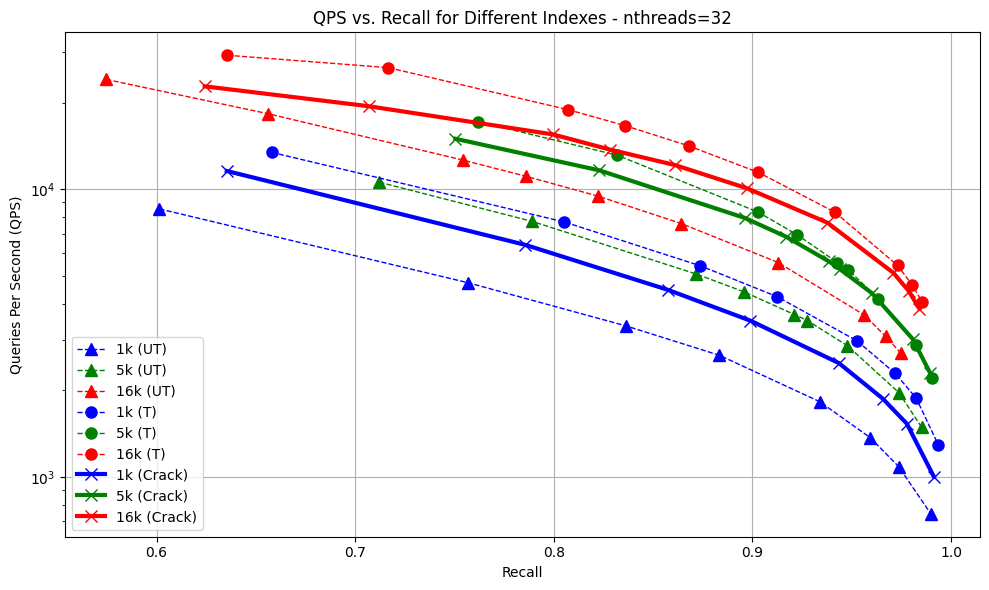

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "^", # Cross for untrained
    "(Crack)": "x",  # Use x for Crack
}

linestyle_styles = {
    "(T)": "--",      # Dashed line for trained
    "(UT)": "--",     # Dashed line for untrained
    "(Crack)": "-",   # Solid line for Crack
}

# Line width for different statuses
line_widths = {
    "(T)": 1,    # Default width for trained
    "(UT)": 1,   # Default width for untrained
    "(Crack)": 3,  # Make Crack line thicker to stand out
}

# Plot results
plt.figure(figsize=(10, 6))
comb_results = results | results_crack  # Combine results

for name, data in comb_results.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)", "(UT)", or "(Crack)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    linestyle = linestyle_styles[status]
    linewidth = line_widths[status]  # Set the line width based on the status
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    
    # Make the Crack line more prominent by adjusting its appearance
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle=linestyle, markersize=8, linewidth=linewidth)

# Title and labels
plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")

# Show grid, legend and plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Get Build times:
- train + add  
OR  
- crack + add  

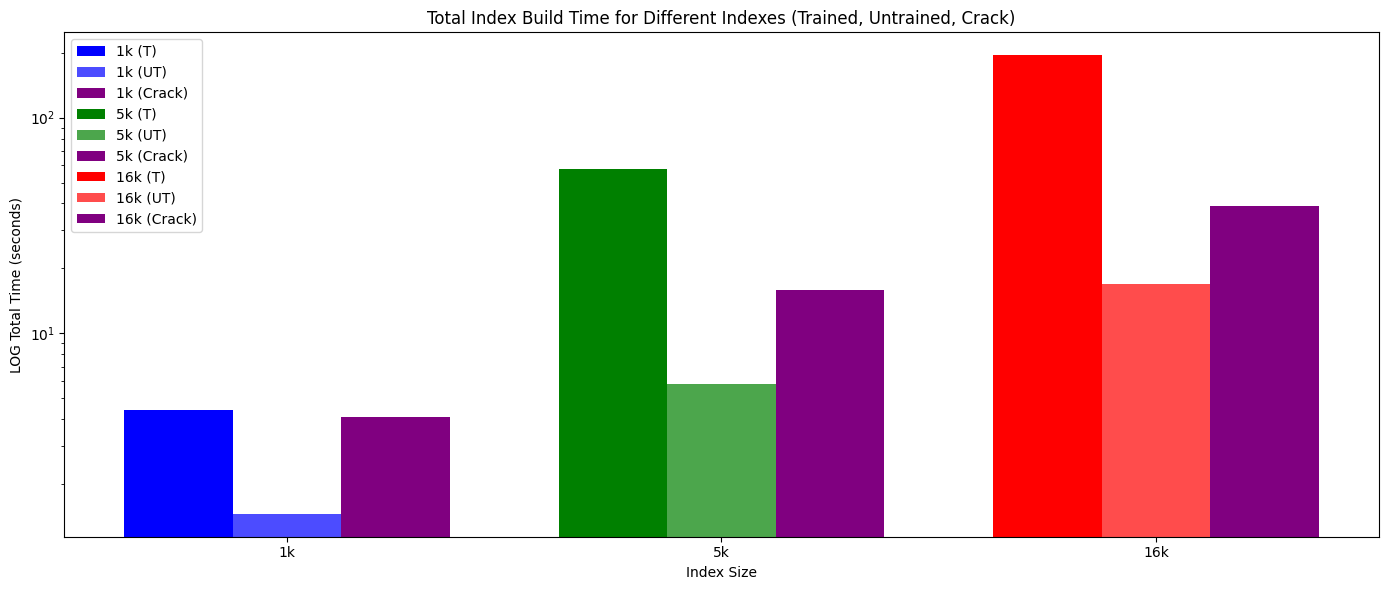

In [29]:
import matplotlib.pyplot as plt

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Store the results for training and adding times
train_times = {
    # trained
    "1k (T)": train_time_1000,
    "5k (T)": train_time_5000,
    "16k (T)": train_time_16000,
    # untrained
    "1k (UT)": train_time_1000_untrained,
    "5k (UT)": train_time_5000_untrained,
    "16k (UT)": train_time_16000_untrained,
    
    # CRACK
    "1k (Crack)": total_build_time['1k (Crack)', 20],
    "5k (Crack)": total_build_time['5k (Crack)', 20],
    "16k (Crack)": total_build_time['16k (Crack)', 20],
}

add_times = {
    # trained
    "1k (T)": add_time_1000,
    "5k (T)": add_time_5000,
    "16k (T)": add_time_16000,
    # untrained
    "1k (UT)": add_time_1000_untrained,
    "5k (UT)": add_time_5000_untrained,
    "16k (UT)": add_time_16000_untrained,
    # ADD same as untrained (same as trained), because we have same starting point
    "1k (Crack)": add_time_1000_untrained,
    "5k (Crack)": add_time_5000_untrained,
    "16k (Crack)": add_time_16000_untrained,
}
# Create lists for plotting
index_labels = ["1k", "5k", "16k"]
total_times_trained = []
total_times_untrained = []
total_times_crack = []

# Collect train and add times for plotting
# Collect train, add, and crack times for plotting
for label in index_labels:
    # Trained
    total_times_trained.append(train_times[f"{label} (T)"] + add_times[f"{label} (T)"])
    # Untrained
    total_times_untrained.append(train_times[f"{label} (UT)"] + add_times[f"{label} (UT)"])
    # Crack
    total_times_crack.append(train_times[f"{label} (Crack)"] + add_times[f"{label} (Crack)"])

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))

# Bar width and positions
bar_width = 0.25  # Adjust for three bars
index_pos = range(len(index_labels))

# Plotting bars
for i, label in enumerate(index_labels):
    # Trained bar
    ax.bar(index_pos[i] - bar_width, total_times_trained[i], bar_width, label=f'{label} (T)', color=index_colors[label])  
    # Untrained bar
    ax.bar(index_pos[i], total_times_untrained[i], bar_width, label=f'{label} (UT)', color=index_colors[label], alpha=0.7)  
    # Crack bar
    ax.bar(index_pos[i] + bar_width, total_times_crack[i], bar_width, label=f'{label} (Crack)', color="purple", alpha=1)  

# Labels and title
ax.set_xlabel('Index Size')
ax.set_ylabel('LOG Total Time (seconds)')
ax.set_title('Total Index Build Time for Different Indexes (Trained, Untrained, Crack)')
ax.set_xticks(index_pos)
ax.set_xticklabels(index_labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.yscale("log")
plt.show()

Get the build timings again:

In [206]:
nthreads=32
faiss.omp_set_num_threads(nthreads)

In [207]:
nlist = 1000
index_1000, train_time_1000, add_time_1000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000, train_time_5000, add_time_5000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000, train_time_16000, add_time_16000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

nlist = 1000
index_1000_untrained, train_time_1000_untrained, add_time_1000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000_untrained, train_time_5000_untrained, add_time_5000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000_untrained, train_time_16000_untrained, add_time_16000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

Kmeans... nlist=1000 km_n_iter=10 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 3607.4496710025414 ms | Add Time = 1410.8465600002091 ms <---IndexIVFFlat::add_core: added 1000000 / 1000000 vectors

Kmeans... nlist=5000 km_n_iter=10 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 60745.93982499937 ms | Add Time = 6101.97052500007 ms <---IndexIVFFlat::add_core: added 1000000 / 1000000 vectors

Kmeans... nlist=16000 km_n_iter=10 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 175521.28073700078 ms | Add Time = 17519.340303999343 ms <---IndexIVFFlat::add_core: added 100

Get skewed dataset number:

In [47]:
xb, xq, xt, gt, metric = load_sift1M(f"/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean")
_, xq, gt, _ = get_skewed_dataset(xb, 
                                skew_on_centroid=0, 
                                nlist=1000, 
                                compute_GT = True, 
                                nearest_cents_to_include=3,
                                seed=42,
                                print_skew=True,
                                plt_skew_nprobe=20,
                                )
xq.shape
desired_limit_queries= 10_000
factor = int(desired_limit_queries / xq.shape[0]) + 1 # duplicate until you have more than target num queires
print(f"{factor=}")
xq, gt = increase_queries_by_duplicates(xq, gt, factor)

Loading sift1M...done


dataset shape:
xb.shape=(1000000, 128)
gt.shape=(10000, 100)
xq.shape=(10000, 128)
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
- Total number of unique centroids visited: 351
- % of total centroids: 35.0 %
factor=4


Run trained/untrained in skewed

In [ ]:
_, xq, gt, _ = get_skewed_dataset(xb, 
                                skew_on_centroid=0, 
                                nlist=1000, 
                                compute_GT = True, 
                                nearest_cents_to_include=3,
                                seed=42,
                                print_skew=True,
                                plt_skew_nprobe=20,
                                )
xq.shape
desired_limit_queries= 10_000
factor = int(desired_limit_queries / xq.shape[0]) + 1 # duplicate until you have more than target num queires
print(f"{factor=}")
xq, gt = increase_queries_by_duplicates(xq, gt, factor)

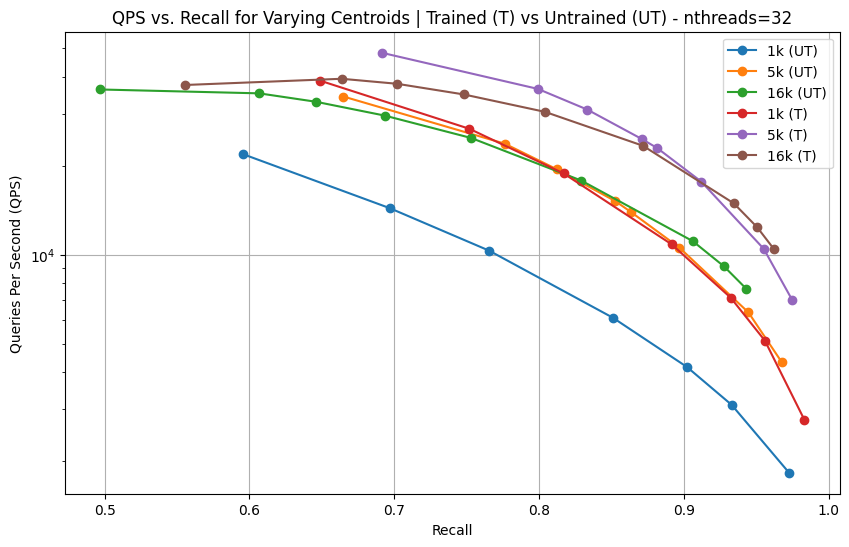

In [49]:
import numpy as np
import time
import matplotlib.pyplot as plt

batch_size = nthreads
topK = 100
nq, d = xq.shape
# I1 = np.empty((nq, topK), dtype="int32")
# D1 = np.empty((nq, topK), dtype="float32")
# I2 = np.empty((nq, topK), dtype="int32")
# D2 = np.empty((nq, topK), dtype="float32")
# I3 = np.empty((nq, topK), dtype="int32")
# D3 = np.empty((nq, topK), dtype="float32")

# Define independent nprobe values for each index
nprobe_values_1000 = [10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (UT)": (index_1000_untrained, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (UT)": (index_5000_untrained, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (UT)": (index_16000_untrained, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "1k (T)": (index_1000, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (T)": (index_5000, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (T)": (index_16000, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results_skewed = {key: [] for key in indexes.keys()}
batch_num = 0
limit_crack = limit_refine = 100
# Iterate over indexes and their independent nprobe values
for name, (index, nprobe_values, I, D) in indexes.items():
    for nprobe in nprobe_values:
        index.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        nq, topK = xq.shape[0], 100
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
                CRACK = REFINE = True
            else:
                CRACK = REFINE = False

            Di, Ii = index.search(xq[i0:i1], k=topK)
            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(t_batch_end - t_batch_start)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)
        qps = nq / total_time
        recall = compute_recall(I, gt, k=topK)
        results_skewed[name].append((qps, recall))

# Plot results_skewed (Recall vs QPS)
plt.figure(figsize=(10, 6))
for name, data in results_skewed.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

- Total number of unique centroids visited: 356
- % of total centroids: 36.0 %


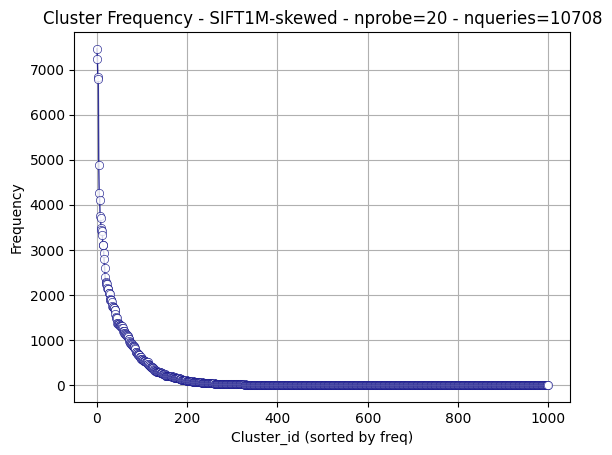

In [48]:
_ = get_centroid_ids_per_query(
        index=index_1000, # D(x)
        # combined_index, # D(x), Q(x) 
        queries=xq,
        nprobe=20,
        plot_hist=True,
        sorted_order=True,
        dataset_name = "SIFT1M-skewed"
    )

Make sure we count all the substeps for cracking:

In [50]:

# ["get_c_visited", "get_p_visited", "crack", "update_invlists", "replace_quantizer", "inner_point_assignments", "inner_km_train"]
detailed_timings

{'search': [0.0053196220032987185],
 'get_c_visited': [0.0008207580031012185],
 'get_p_visited': [0.027703202002157923],
 'inner_km_train': [0.09366084900102578],
 'inner_point_assignments': [0.08831264599575661],
 'replace_quantizer': [0.0016971680015558377],
 'update_invlists': [0.003029875995707698],
 'crack': [0.0070287299968185835]}

Kmeans... nlist=1000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 125.98118599998998 ms | Add Time = 1174.9129349991563 ms <---IndexIVFFlat::add_core: added 1000000 / 1000000 vectors

Kmeans... nlist=5000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 58.3521570006269 ms | Add Time = 5610.580527005368 ms <---IndexIVFFlat::add_core: added 1000000 / 1000000 vectors

Kmeans... nlist=16000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 61.03706000430975 ms | Add Time = 16956.32114000182 ms <---IndexIVFFlat::add_core: added 1000000 

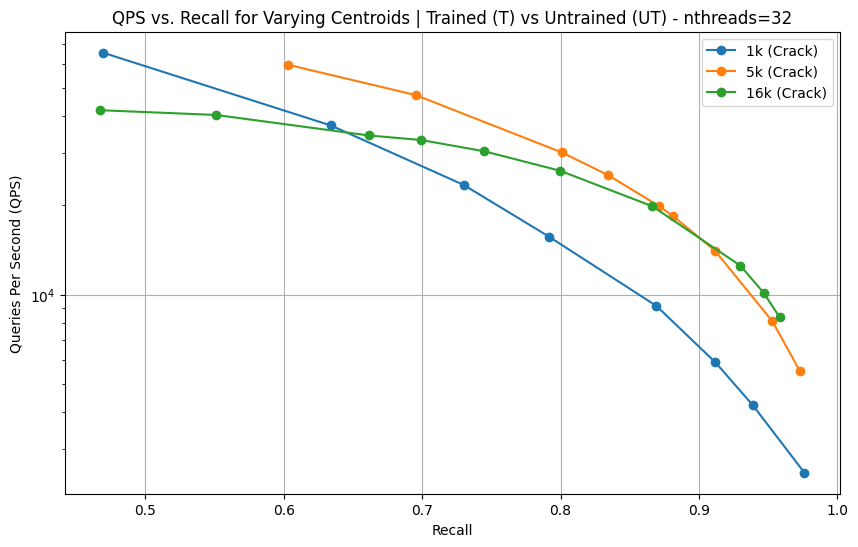

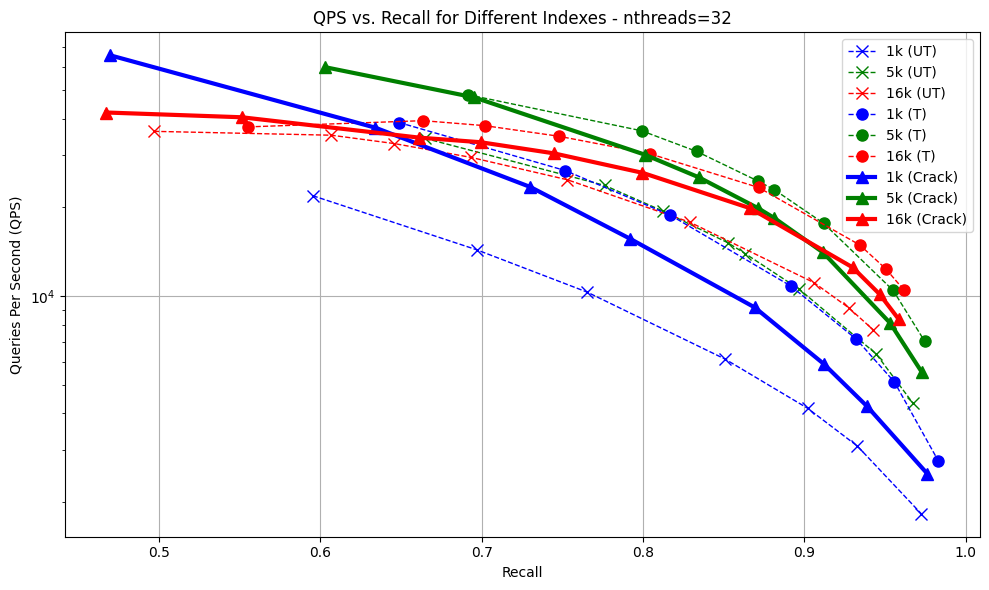

In [70]:
# Cracking:
nlist = 1000
index_1000_crack, train_time_1000_crack, add_time_1000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000_crack, train_time_5000_crack, add_time_5000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000_crack, train_time_16000_crack, add_time_16000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

########################################

batch_size = nthreads
topK = 100
nq, d = xq.shape

# # Define independent nprobe values for each index
nprobe_values_1000 = [5, 10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [20, 30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [20, 30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (Crack)": (index_1000_crack, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (Crack)": (index_5000_crack, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (Crack)": (index_16000_crack, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results_crack_skew = {key: [] for key in indexes.keys()}

# Iterate over indexes and their independent nprobe values

build_times_crack_skew = defaultdict(list)

for name, (index, nprobe_values, I, D) in indexes.items():

    if "1k" in name:
        refine_nprobe = 50
        limit_crack = limit_refine = 10
    elif "5k" in name:
        refine_nprobe = 500
        limit_crack = limit_refine = 10
    elif "16k" in name:
        refine_nprobe = 1000
        limit_crack = limit_refine = 10

    for nprobe in nprobe_values:
        index_to_crack = faiss.clone_index(index) # reset to start each time
        _ = init_centroids_after_assignments(index_to_crack, metric=metric) # init cents

        index_to_crack.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        batch_num = 0
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            # if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
            if batch_num <= limit_crack and batch_num <= limit_refine: 
                CRACK = REFINE = True
            else:
                CRACK = REFINE = False
            # dynamic_nprobe = min(nprobe, index.nlist)
            index_to_crack, Di, Ii, detailed_timings, d_nprobe = search_crack_refine_single(
                index_to_crack,
                xq[i0:i1],
                nprobe=nprobe,
                k=topK,
                refine_niter=1,
                CRACK=CRACK,
                REFINE=REFINE,
                # refine_nprobe_factor=None,
                metric=metric,
                refine_nprobe=refine_nprobe,
            )

            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(detailed_timings["search"][0])
            
            # total time of build from individual operations
            total_time = 0
            for key in ["get_c_visited", "get_p_visited", "crack", "update_invlists", "replace_quantizer", "inner_point_assignments", "inner_km_train"]:
                # Safely check if the list is empty before accessing the first element
                timings_list = detailed_timings.get(key, [])
                if timings_list:
                    total_time += timings_list[0]  # Add the first element of the list
                else:
                    total_time += 0  # Default to 0 if the list is empty or not found
                
            build_times_crack_skew[(name, nprobe)].append(total_time)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)
        qps = nq / total_time
        recall = compute_recall(I, gt, k=topK)
        results_crack_skew[name].append((qps, recall))

# results.extend(results_crack)
# Plot results (Recall vs QPS)
comb_results_skew = results_skewed | results_crack_skew
plt.figure(figsize=(10, 6))
for name, data in results_crack_skew.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "x", # Cross for untrained
    "(Crack)": "^",
}

linestyle_styles = {
    "(T)": "--",      # Solid line for trained
    "(UT)": "--",    # Dashed line for untrained
    "(Crack)": "-", # Dash-dot line for Crack
}

# Line width for different statuses
line_widths = {
    "(T)": 1,    # Default width for trained
    "(UT)": 1,   # Default width for untrained
    "(Crack)": 3,  # Make Crack line thicker to stand out
}

# Plot results
plt.figure(figsize=(10, 6))
comb_results_skew = results_skewed | results_crack_skew

for name, data in comb_results_skew.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)", "(UT)", or "(Crack)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    linestyle = linestyle_styles[status]
    linewidth = line_widths[status]  # Set the line width based on the status
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    
    # Make the Crack line more prominent by adjusting its appearance
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle=linestyle, markersize=8, linewidth=linewidth)

# Title and labels
plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")

# Show grid, legend and plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Better loooking plot

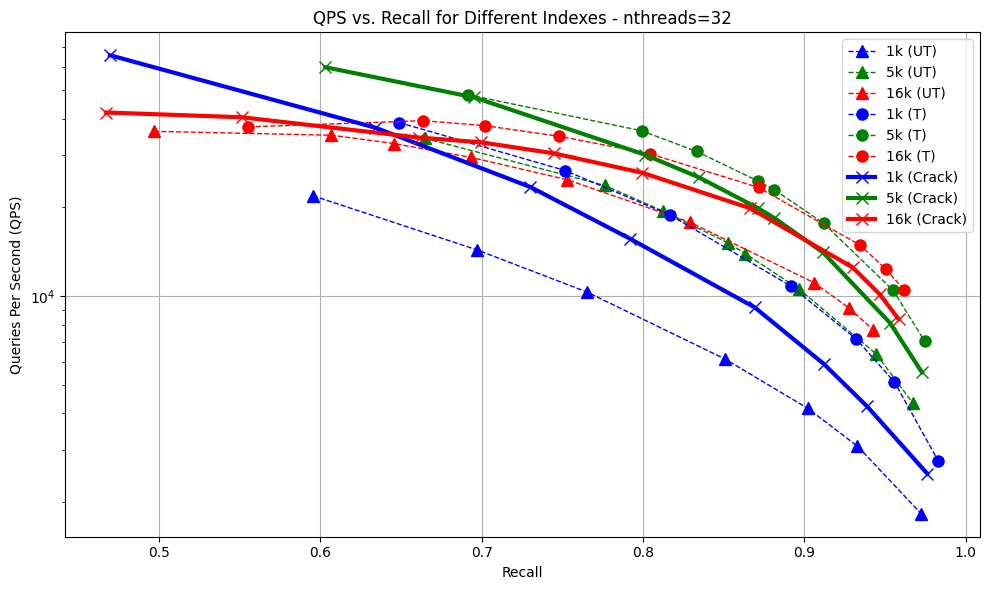

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "^", # Cross for untrained
    "(Crack)": "x",  # Use x for Crack
}

linestyle_styles = {
    "(T)": "--",      # Dashed line for trained
    "(UT)": "--",     # Dashed line for untrained
    "(Crack)": "-",   # Solid line for Crack
}

# Line width for different statuses
line_widths = {
    "(T)": 1,    # Default width for trained
    "(UT)": 1,   # Default width for untrained
    "(Crack)": 3,  # Make Crack line thicker to stand out
}

# Plot results
plt.figure(figsize=(10, 6))
comb_results_skew = results_skewed | results_crack_skew

for name, data in comb_results_skew.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)", "(UT)", or "(Crack)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    linestyle = linestyle_styles[status]
    linewidth = line_widths[status]  # Set the line width based on the status
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    
    # Make the Crack line more prominent by adjusting its appearance
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle=linestyle, markersize=8, linewidth=linewidth)

# Title and labels
plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")

# Show grid, legend and plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Build times (w/ skewed) : 

In [72]:
# crack times during serach [ need to all add the .add() time at the start... ]
total_build_time_skew = {}
for k,v in build_times_crack_skew.items():
    total_build_time_skew[k] = sum(v)
    print(k, total_build_time_skew[k])

('1k (Crack)', 5) 0.3509354850248201
('1k (Crack)', 10) 0.3606507719887304
('1k (Crack)', 15) 0.36476041501009604
('1k (Crack)', 20) 0.3615433919840143
('1k (Crack)', 30) 0.36642158703762107
('1k (Crack)', 40) 0.3599197119838209
('1k (Crack)', 50) 0.363653969950974
('1k (Crack)', 75) 0.5958094910020009
('5k (Crack)', 20) 1.9795717439919827
('5k (Crack)', 30) 1.954975575012213
('5k (Crack)', 50) 2.005087724981422
('5k (Crack)', 60) 2.0044612779893214
('5k (Crack)', 75) 2.019611525007349
('5k (Crack)', 80) 1.99355584703153
('5k (Crack)', 100) 1.9786796600237722
('5k (Crack)', 150) 1.9908080990062444
('5k (Crack)', 200) 1.985943966996274
('16k (Crack)', 20) 2.2280557429767214
('16k (Crack)', 30) 2.2443753690167796
('16k (Crack)', 50) 2.1868959159837686
('16k (Crack)', 60) 2.1748537980020046
('16k (Crack)', 75) 2.2308569909873768
('16k (Crack)', 100) 2.210494278013357
('16k (Crack)', 150) 2.233658686025592
('16k (Crack)', 250) 2.24169948996132
('16k (Crack)', 300) 2.2594944869852043
('16k 

In [73]:
total_build_time_skew

{('1k (Crack)', 5): 0.3509354850248201,
 ('1k (Crack)', 10): 0.3606507719887304,
 ('1k (Crack)', 15): 0.36476041501009604,
 ('1k (Crack)', 20): 0.3615433919840143,
 ('1k (Crack)', 30): 0.36642158703762107,
 ('1k (Crack)', 40): 0.3599197119838209,
 ('1k (Crack)', 50): 0.363653969950974,
 ('1k (Crack)', 75): 0.5958094910020009,
 ('5k (Crack)', 20): 1.9795717439919827,
 ('5k (Crack)', 30): 1.954975575012213,
 ('5k (Crack)', 50): 2.005087724981422,
 ('5k (Crack)', 60): 2.0044612779893214,
 ('5k (Crack)', 75): 2.019611525007349,
 ('5k (Crack)', 80): 1.99355584703153,
 ('5k (Crack)', 100): 1.9786796600237722,
 ('5k (Crack)', 150): 1.9908080990062444,
 ('5k (Crack)', 200): 1.985943966996274,
 ('16k (Crack)', 20): 2.2280557429767214,
 ('16k (Crack)', 30): 2.2443753690167796,
 ('16k (Crack)', 50): 2.1868959159837686,
 ('16k (Crack)', 60): 2.1748537980020046,
 ('16k (Crack)', 75): 2.2308569909873768,
 ('16k (Crack)', 100): 2.210494278013357,
 ('16k (Crack)', 150): 2.233658686025592,
 ('16k (Crac

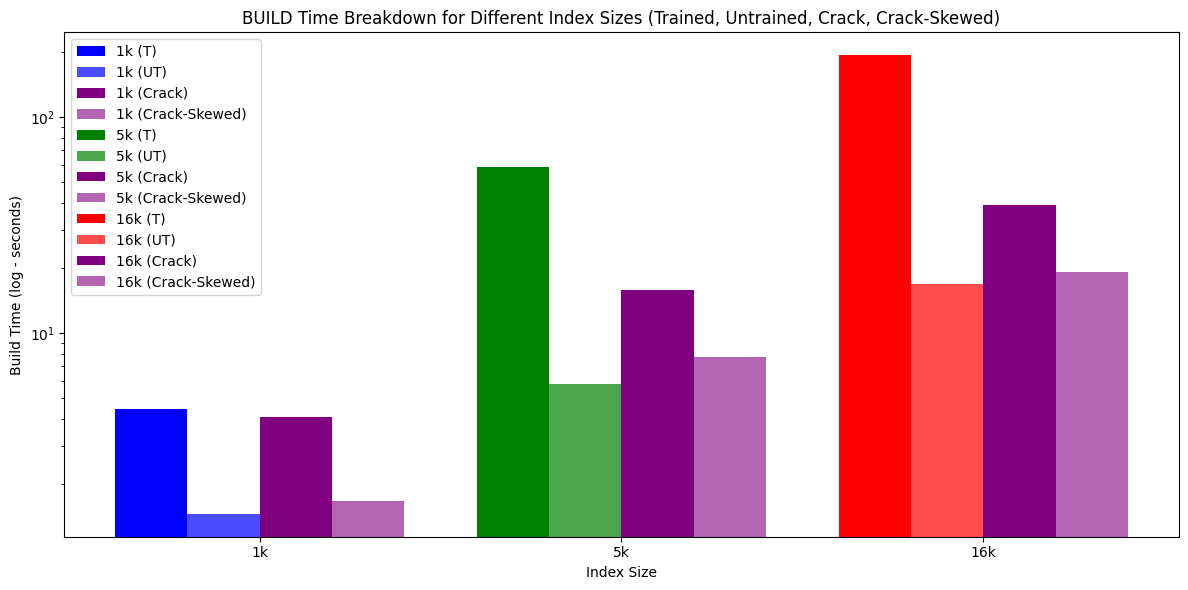

In [80]:
import matplotlib.pyplot as plt

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Store the results for training and adding times
train_times = {
    # trained
    "1k (T)": train_time_1000,
    "5k (T)": train_time_5000,
    "16k (T)": train_time_16000,
    # untrained
    "1k (UT)": train_time_1000_untrained,
    "5k (UT)": train_time_5000_untrained,
    "16k (UT)": train_time_16000_untrained,
    
    # CRACK
    "1k (Crack)": total_build_time['1k (Crack)', 20],
    "5k (Crack)": total_build_time['5k (Crack)', 20],
    "16k (Crack)": total_build_time['16k (Crack)', 20],

    # Crack Skewed
    "1k (Crack-Skewed)": total_build_time_skew['1k (Crack)', 20],
    "5k (Crack-Skewed)": total_build_time_skew['5k (Crack)', 20],
    "16k (Crack-Skewed)": total_build_time_skew['16k (Crack)', 20],
}

add_times = {
    # Keep add the same everywhere for simplicity... to avoid cold starts variation
    # trained
    "1k (T)": add_time_1000_untrained,
    "5k (T)": add_time_5000_untrained,
    "16k (T)": add_time_16000_untrained,
    # untrained
    "1k (UT)": add_time_1000_untrained,
    "5k (UT)": add_time_5000_untrained,
    "16k (UT)": add_time_16000_untrained,
    # ADD same as untrained (same as trained), because we have same starting point
    "1k (Crack)": add_time_1000_untrained,
    "5k (Crack)": add_time_5000_untrained,
    "16k (Crack)": add_time_16000_untrained,
    # ADD is same again... ( slight variation but keep it same for simplicity)
    "1k (Crack-Skewed)": add_time_1000_untrained,
    "5k (Crack-Skewed)": add_time_5000_untrained,
    "16k (Crack-Skewed)": add_time_16000_untrained,
}

# Create lists for plotting
index_labels = ["1k", "5k", "16k"]
total_times_trained = []
total_times_untrained = []
total_times_crack = []
total_times_crack_skewed = []

# Collect train, add, and crack times for plotting
for label in index_labels:
    # Trained
    total_times_trained.append(train_times[f"{label} (T)"] + add_times[f"{label} (T)"])
    # Untrained
    total_times_untrained.append(train_times[f"{label} (UT)"] + add_times[f"{label} (UT)"])
    # Crack
    total_times_crack.append(train_times[f"{label} (Crack)"] + add_times[f"{label} (Crack)"])
    # Crack Skewed
    total_times_crack_skewed.append(train_times[f"{label} (Crack-Skewed)"] + add_times[f"{label} (Crack-Skewed)"])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and positions
bar_width = 0.2  # Adjust for four bars
index_pos = range(len(index_labels))

# Plotting bars
for i, label in enumerate(index_labels):
    # Trained bar
    ax.bar(index_pos[i] - 1.5 * bar_width, total_times_trained[i], bar_width, label=f'{label} (T)', color=index_colors[label])  
    # Untrained bar
    ax.bar(index_pos[i] - 0.5 * bar_width, total_times_untrained[i], bar_width, label=f'{label} (UT)', color=index_colors[label], alpha=0.7)  
    # Crack bar
    ax.bar(index_pos[i] + 0.5 * bar_width, total_times_crack[i], bar_width, label=f'{label} (Crack)', color="purple", alpha=1)  
    # Crack Skewed bar (different shade of purple)
    ax.bar(index_pos[i] + 1.5 * bar_width, total_times_crack_skewed[i], bar_width, label=f'{label} (Crack-Skewed)', color="purple", alpha=0.6)  

# Labels and title
ax.set_xlabel('Index Size')
ax.set_ylabel('Build Time (log - seconds)')
ax.set_title('BUILD Time Breakdown for Different Index Sizes (Trained, Untrained, Crack, Crack-Skewed)')
ax.set_xticks(index_pos)
ax.set_xticklabels(index_labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.yscale("log")
plt.show()

# Voronoi Example

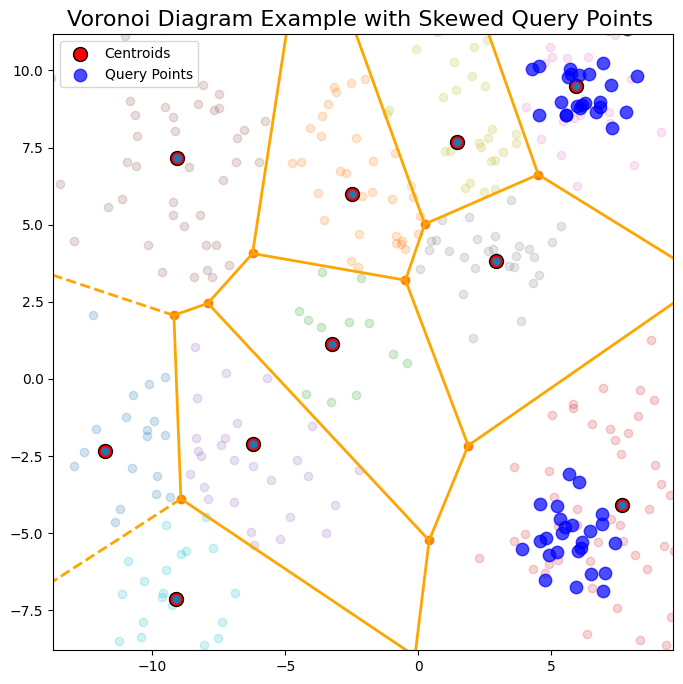

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

seed = 13
queries_seed = 13


# Step 1: Generate clustered data points
n_clusters = 15  # Number of clusters for main data
data_points, _ = make_blobs(n_samples=300, centers=n_clusters, cluster_std=2, random_state=seed)

# Step 2: Compute centroids using KMeans
nlist = 10
kmeans = KMeans(n_clusters=nlist, random_state=seed, init="random", max_iter=1)
kmeans.fit(data_points)
centroids = kmeans.cluster_centers_

# Step 3: Generate query points
query_points, _ = make_blobs(n_samples=50, centers=2, cluster_std=1, random_state=queries_seed)

# Step 4: Compute the Voronoi diagram using the centroids
vor = Voronoi(centroids)

# Step 5: Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(8, 8))

# Plot original data points with cluster coloring
for i in range(n_clusters):
    cluster_points = data_points[kmeans.labels_ == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.2)#, label=f'Cluster {i+1}')

# Plot Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='orange',
                line_width=2, point_size=10)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, label='Centroids', edgecolor='black')

# Plot query points
ax.scatter(query_points[:, 0], query_points[:, 1], c='blue', alpha=0.7, s=80, label='Query Points')

# Customize plot appearance
ax.set_title("Voronoi Diagram Example with Skewed Query Points ", fontsize=16)
ax.legend(loc='upper left')
plt.show()


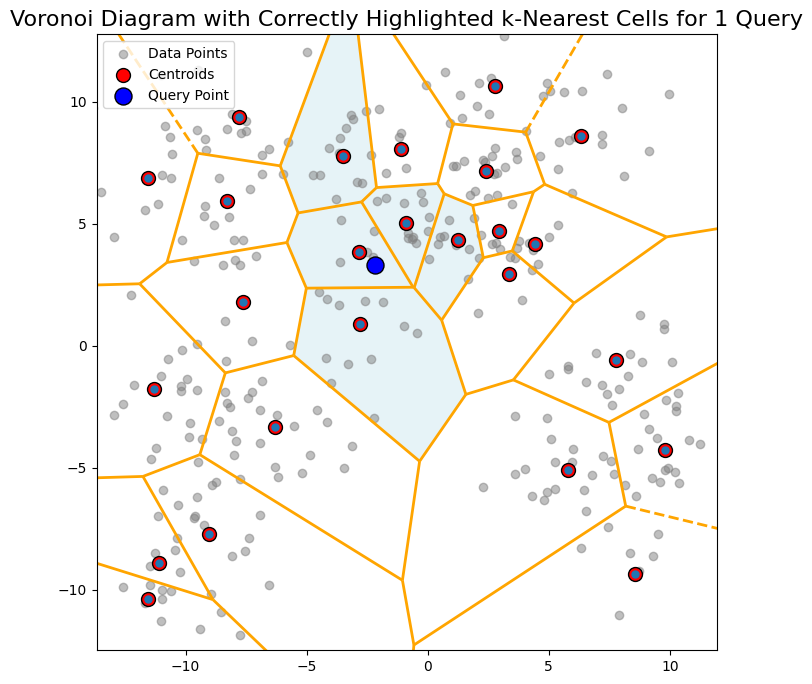

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist

seed = 13
queries_seed = 1

# Step 1: Generate clustered data points
n_clusters = 15  # Number of clusters for main data
data_points, _ = make_blobs(n_samples=300, centers=n_clusters, cluster_std=2, random_state=seed)

# Step 2: Compute centroids using KMeans
nlist = 25
kmeans = KMeans(n_clusters=nlist, random_state=seed, init="random", max_iter=1)
kmeans.fit(data_points)
centroids = kmeans.cluster_centers_

# Step 3: Generate a single query point
query_points, _ = make_blobs(n_samples=1, centers=2, cluster_std=1, random_state=queries_seed)

# Step 4: Compute the Voronoi diagram using the centroids
vor = Voronoi(centroids)

# Function to find the k nearest centroids for each query
def find_k_nearest_cells(query_points, centroids, k=3):
    distances = cdist(query_points, centroids)  # Compute distances between queries and centroids
    nearest_indices = np.argsort(distances, axis=1)[:, :k]  # Get indices of the k nearest centroids
    return nearest_indices

# Step 5: Find k nearest cells for the query point
k = 5  # Number of nearest cells to highlight
nearest_cells = find_k_nearest_cells(query_points, centroids, k)

# Step 6: Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(8, 8))

# Highlight Voronoi cells corresponding to k nearest centroids
query_colors = ['lightblue']  # Color for the query region
for q_idx, cell_indices in enumerate(nearest_cells):
    for cell_idx in cell_indices:
        region_index = vor.point_region[cell_idx]
        region = vor.regions[region_index]
        if -1 not in region:  # Exclude infinite regions
            polygon = [vor.vertices[i] for i in region]
            ax.fill(*zip(*polygon), color=query_colors[q_idx], alpha=0.3)

# Plot original data points
ax.scatter(data_points[:, 0], data_points[:, 1], c='gray', alpha=0.5, label='Data Points')

# Plot Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange',
                line_width=2, point_size=10)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, label='Centroids', edgecolor='black')

# Plot query point
ax.scatter(query_points[:, 0], query_points[:, 1], c='blue', s=150, label='Query Point', edgecolor='black')

# Customize plot appearance
ax.set_title("Voronoi Diagram with Correctly Highlighted k-Nearest Cells for 1 Query", fontsize=16)
ax.legend(loc='upper left')
plt.show()


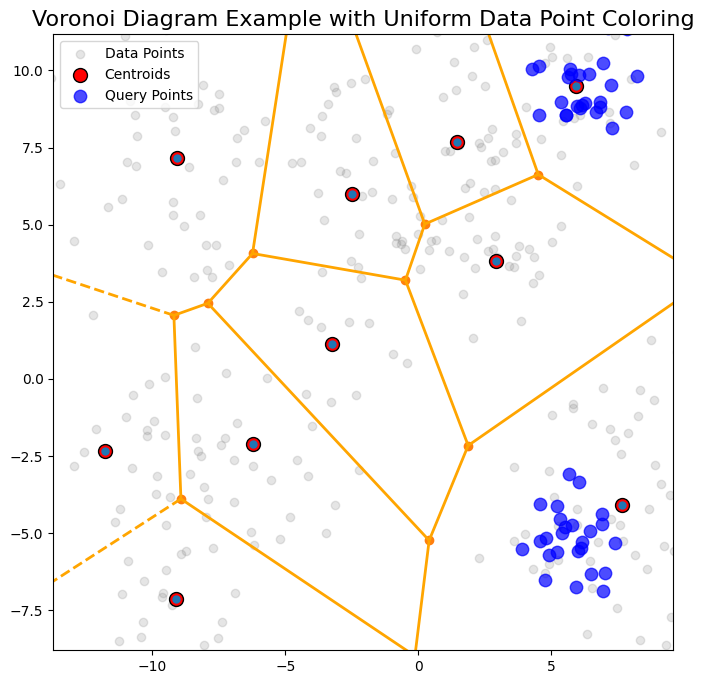

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

seed = 13
queries_seed = 13

# Step 1: Generate clustered data points
n_clusters = 15  # Number of clusters for main data
data_points, _ = make_blobs(n_samples=300, centers=n_clusters, cluster_std=2, random_state=seed)

# Step 2: Compute centroids using KMeans
nlist = 10
kmeans = KMeans(n_clusters=nlist, random_state=seed, init="random", max_iter=1)
kmeans.fit(data_points)
centroids = kmeans.cluster_centers_

# Step 3: Generate query points
query_points, _ = make_blobs(n_samples=50, centers=2, cluster_std=1, random_state=queries_seed)

# Step 4: Compute the Voronoi diagram using the centroids
vor = Voronoi(centroids)

# Step 5: Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all data points with the same color
ax.scatter(data_points[:, 0], data_points[:, 1], c='gray', alpha=0.2, label="Data Points")

# Plot Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='orange',
                line_width=2, point_size=10)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, label='Centroids', edgecolor='black')

# Plot query points
ax.scatter(query_points[:, 0], query_points[:, 1], c='blue', alpha=0.7, s=80, label='Query Points')

# Customize plot appearance
ax.set_title("Voronoi Diagram Example with Uniform Data Point Coloring", fontsize=16)
ax.legend(loc='upper left')
plt.show()


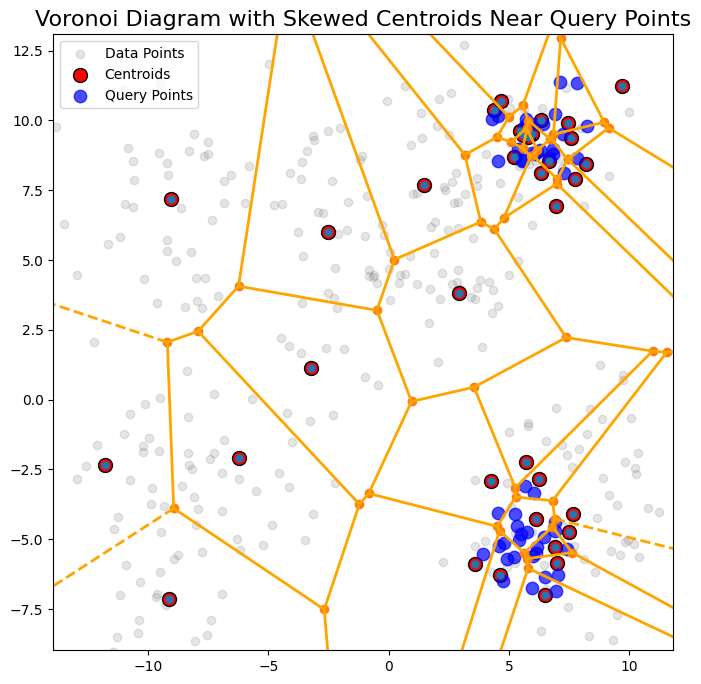

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

seed = 13
queries_seed = 13


def generate_skewed_centroids(data_points, query_points, nlist=10, extra_centroids_factor=2):
    """
    Generate centroids with extra focus on the areas around the query points.
    """
    # Step 1: Initial centroids using KMeans
    kmeans = KMeans(n_clusters=nlist, random_state=seed, init="random", max_iter=1)
    kmeans.fit(data_points)
    centroids = kmeans.cluster_centers_

    # Step 2: Add extra centroids around query points
    n_extra = int(len(query_points) * extra_centroids_factor * 0.5)
    extra_centroids, _ = make_blobs(n_samples=n_extra, centers=query_points, cluster_std=1, random_state=seed)

    # Combine original and extra centroids
    skewed_centroids = np.vstack([centroids, extra_centroids])
    return skewed_centroids


# Step 1: Generate clustered data points
n_clusters = 15  # Number of clusters for main data
data_points, _ = make_blobs(n_samples=300, centers=n_clusters, cluster_std=2, random_state=seed)

# Step 2: Generate query points
query_points, _ = make_blobs(n_samples=50, centers=2, cluster_std=1, random_state=queries_seed)

# Step 3: Generate centroids with extra focus on query regions
nlist = 10
extra_centroids_factor = 1 # Control number of extra centroids near query points
centroids = generate_skewed_centroids(data_points, query_points, nlist=nlist, extra_centroids_factor=extra_centroids_factor)

# Step 4: Compute the Voronoi diagram using the centroids
vor = Voronoi(centroids)

# Step 5: Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(8, 8))

# Plot original data points with cluster coloring
ax.scatter(data_points[:, 0], data_points[:, 1], c="grey", alpha=0.2, label="Data Points")

# Plot Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='orange',
                line_width=2, point_size=10)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, label='Centroids', edgecolor='black')

# Plot query points
ax.scatter(query_points[:, 0], query_points[:, 1], c='blue', alpha=0.7, s=80, label='Query Points')

# Customize plot appearance
ax.set_title("Voronoi Diagram with Skewed Centroids Near Query Points", fontsize=16)
ax.legend(loc='upper left')
plt.show()


In [14]:
seed = 13
queries_seed = 13

# Re-run for sift1m slice out of sit1b

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vasili_helpers import *
from collections import defaultdict
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100) # print all rows
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last"

%load_ext autoreload
%autoreload 2

In [2]:
# big-ann sift1m

dbsize = int("SIFT1M"[4:-1])

# dataset_dir = '/mnt/scratch/wenqi/Faiss_experiments/bigann'
# CHEF NOTE: reading from bigann benchmark SIFT1M, SIFT10M, SIFT100M, SIFT1B (or 1000M not sure)
dataset_dir = "/pub/scratch/vmageirakos/datasets/bigann"
# CHEF when I download SIFT1B use this:
xb = mmap_bvecs(os.path.join(dataset_dir, 'bigann_base.bvecs'))
xq = mmap_bvecs(os.path.join(dataset_dir, 'bigann_query.bvecs'))
gt = ivecs_read(os.path.join(dataset_dir, 'gnd/idx_%dM.ivecs' % dbsize))

# trim xb to correct size
xb = xb[:dbsize * 1000 * 1000]

# Wenqi: load xq to main memory and reshape
xq = xq.astype("float32").copy()
xq = np.array(xq, dtype=np.float32)
gt = np.array(gt, dtype=np.int32)
metric = 'euclidean'

In [50]:
nthreads=128
faiss.omp_set_num_threads(nthreads)

In [4]:
nlist = 1000
index_1000, train_time_1000, add_time_1000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000, train_time_5000, add_time_5000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000, train_time_16000, add_time_16000 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=10,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

nlist = 1000
index_1000_untrained, train_time_1000_untrained, add_time_1000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000_untrained, train_time_5000_untrained, add_time_5000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000_untrained, train_time_16000_untrained, add_time_16000_untrained = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

Kmeans... nlist=1000 km_n_iter=10 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 4207.890482000948 ms | Add Time = 1859.622367999691 ms <---
Kmeans... nlist=5000 km_n_iter=10 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 57202.823619998526 ms | Add Time = 6451.944962995185 ms <---
Kmeans... nlist=16000 km_n_iter=10 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 178160.67707400362 ms | Add Time = 191

In [51]:
nlist = 1000
index_1000_niter_1, train_time_1000_niter_1, add_time_1000_niter_1 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=1,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000_niter_1, train_time_5000_niter_1, add_time_5000_niter_1 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=1,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000_niter_1, train_time_16000_niter_1, add_time_16000_niter_1 = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=1,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

Kmeans... nlist=1000 km_n_iter=1 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 518.0224799987627 ms | Add Time = 1589.3342869967455 ms <---
Kmeans... nlist=5000 km_n_iter=1 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 5984.617721995164 ms | Add Time = 6172.253471995646 ms <---
Kmeans... nlist=16000 km_n_iter=1 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 18532.462691997353 ms | Add Time = 18394.183696000255 ms <---IndexIVFFlat::add_core: added 100000

In [52]:
nthreads=32
faiss.omp_set_num_threads(nthreads)

In [16]:
# results_copy = results.copy()
results_copy

{'1k (UT)': [(8431.07274338238, 0.583857),
  (4545.406595286066, 0.729942),
  (3263.251978620232, 0.805215),
  (2612.422247495654, 0.851606),
  (1801.2263476308733, 0.905965),
  (1353.7148555478343, 0.936005),
  (1099.1751800457198, 0.954495),
  (749.2026075351001, 0.978255)],
 '5k (UT)': [(13836.801555269883, 0.699505),
  (10304.399970349532, 0.772331),
  (6750.879040308536, 0.851859),
  (5780.531948200584, 0.875996),
  (4803.1613771028115, 0.902184),
  (4584.688362032952, 0.909104),
  (3779.982111735467, 0.930823),
  (2651.16735757978, 0.960926),
  (2068.3572572973617, 0.975757)],
 '16k (UT)': [(26687.538381978306, 0.570375),
  (22643.429660657832, 0.649303),
  (16178.698721781311, 0.742017),
  (14103.65410273931, 0.772697),
  (12421.3180769753, 0.80765),
  (10032.485408247647, 0.848587),
  (7348.015536672878, 0.897775),
  (4840.040052154217, 0.943799),
  (4182.440787522476, 0.955988),
  (3686.289375070446, 0.964793)],
 '1k (T)': [(12992.148632283717, 0.658902),
  (7289.6731115393395

In [ ]:
# results_crack_copy = results_crack.copy()
results_crack

{'1k (Crack)': [(10782.149505093212, 0.623429),
  (5798.7058868601725, 0.764568),
  (4274.747842960062, 0.833912),
  (3358.5958196728307, 0.875276),
  (2413.342665672383, 0.922796),
  (1846.6824323501114, 0.948284),
  (1500.102298470255, 0.963541),
  (1018.4100450524096, 0.982674)],
 '5k (Crack)': [(14411.61395488365, 0.742885),
  (10674.831559966164, 0.81108),
  (7297.799495274368, 0.881459),
  (6350.8123133942445, 0.902505),
  (5358.590387140842, 0.924509),
  (5005.126564311789, 0.930224),
  (4143.19133835861, 0.947965),
  (2894.266441001758, 0.971471),
  (2200.035812362917, 0.982655)],
 '16k (Crack)': [(22735.013288812625, 0.623869),
  (19219.39893014821, 0.700312),
  (15818.416306215418, 0.786837),
  (14314.150267154972, 0.814787),
  (12332.574753444816, 0.846034),
  (10287.725833736902, 0.882074),
  (7781.926091246399, 0.923746),
  (5238.4731891325055, 0.960515),
  (4544.239367056371, 0.970046),
  (3989.044919691272, 0.976539)]}

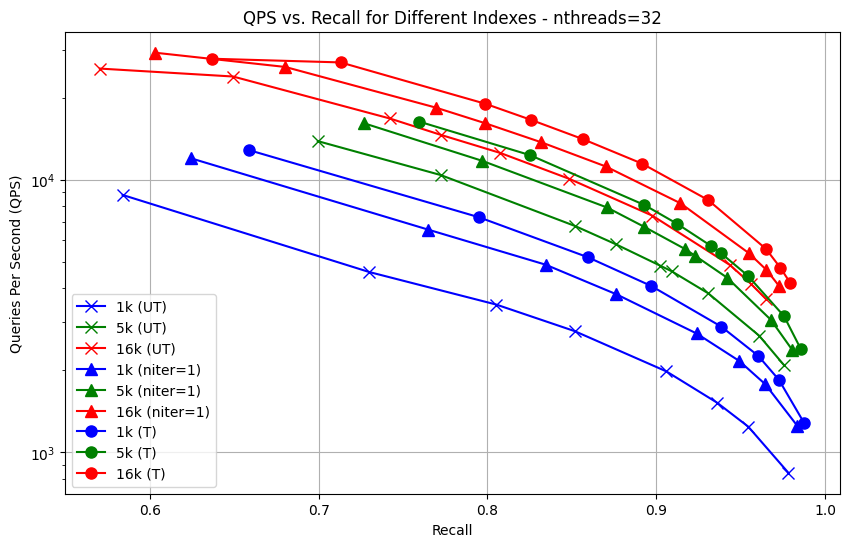

In [22]:
import numpy as np
import time
import matplotlib.pyplot as plt

batch_size = nthreads
topK = 100
nq, d = xq.shape

# Define independent nprobe values for each index
nprobe_values_1000 = [5, 10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [20, 30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [20, 30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (UT)": (index_1000_untrained, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (UT)": (index_5000_untrained, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (UT)": (index_16000_untrained, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),

    "1k (niter=1)": (index_1000_niter_1, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (niter=1)": (index_5000_niter_1, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (niter=1)": (index_16000_niter_1, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    
    "1k (T)": (index_1000, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (T)": (index_5000, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (T)": (index_16000, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results = {key: [] for key in indexes.keys()}
batch_num = 0
# limit_crack = limit_refine = 100
# Iterate over indexes and their independent nprobe values
for name, (index, nprobe_values, I, D) in indexes.items():
    for nprobe in nprobe_values:
        index.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        nq, topK = xq.shape[0], 100
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            # if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
            #     CRACK = REFINE = True
            # else:
            #     CRACK = REFINE = False

            Di, Ii = index.search(xq[i0:i1], k=topK)
            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(t_batch_end - t_batch_start)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)
        qps = nq / total_time
        recall = compute_recall(I, gt, k=topK)
        results[name].append((qps, recall))

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "x",  # Cross for untrained
    "(niter=1)": "."  # Cross for untrained
}

# Plot results
plt.figure(figsize=(10, 6))

for name, data in results.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)" or "(UT)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle='-', markersize=8)

plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

Kmeans... nlist=1000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 180.71511999733048 ms | Add Time = 1371.0479159999522 ms <---
Kmeans... nlist=5000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 154.09701700264122 ms | Add Time = 5925.547234997794 ms <---
Kmeans... nlist=16000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 159.12733400182333 ms | Add Time = 18421.473440001137 ms <---IndexIVFFlat::add_core: added 1000

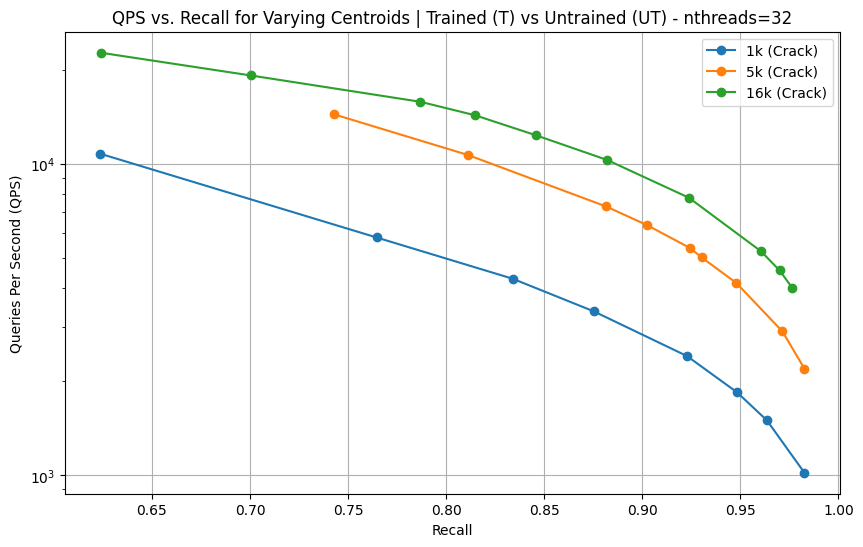

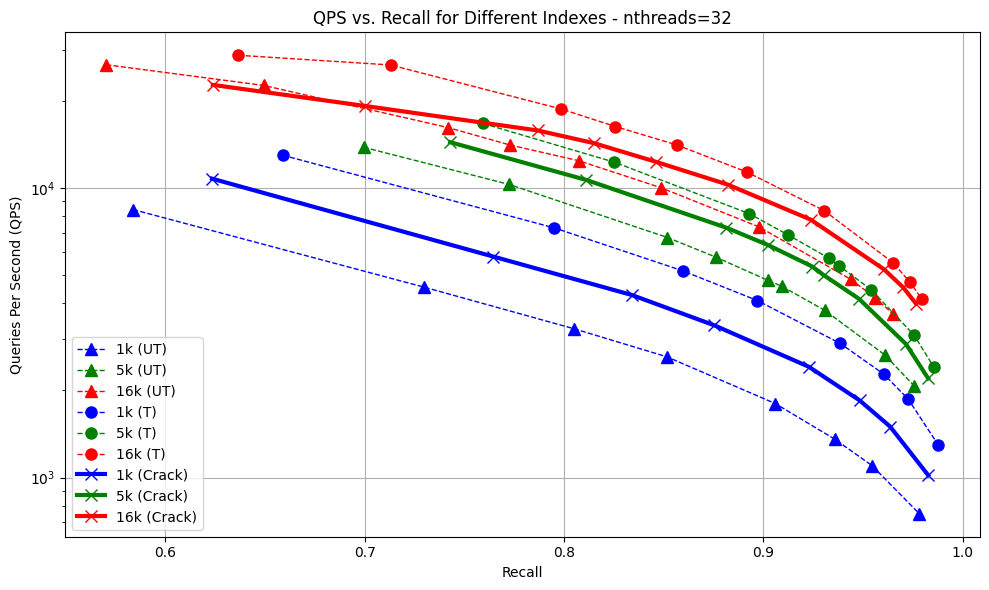

In [7]:
# Cracking:
nlist = 1000
index_1000_crack, train_time_1000_crack, add_time_1000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000_crack, train_time_5000_crack, add_time_5000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000_crack, train_time_16000_crack, add_time_16000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

########################################

batch_size = nthreads
topK = 100
nq, d = xq.shape

# Define independent nprobe values for each index
nprobe_values_1000 = [5, 10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [20, 30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [20, 30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (Crack)": (index_1000_crack, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (Crack)": (index_5000_crack, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (Crack)": (index_16000_crack, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results_crack = {key: [] for key in indexes.keys()}

# Iterate over indexes and their independent nprobe values

build_times_crack = defaultdict(list)

for name, (index, nprobe_values, I, D) in indexes.items():

    if "1k" in name:
        refine_nprobe = 100
        limit_crack = limit_refine = 30
    elif "5k" in name:
        refine_nprobe = 500
        limit_crack = limit_refine = 50
    elif "16k" in name:
        refine_nprobe = 1000
        limit_crack = limit_refine = 100

    for nprobe in nprobe_values:
        # CHEF SOS NOTE: INIT CENTROIDS
        index_to_crack = faiss.clone_index(index) # reset to start each time
        _ = init_centroids_after_assignments(index_to_crack, metric=metric) # init cents

        index_to_crack.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        batch_num = 0
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            # if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
            if batch_num <= limit_crack and batch_num <= limit_refine: 
                CRACK = REFINE = True
            else:
                CRACK = REFINE = False
            # dynamic_nprobe = min(nprobe, index.nlist)
            index_to_crack, Di, Ii, detailed_timings, d_nprobe = search_crack_refine_single(
                index_to_crack,
                xq[i0:i1],
                nprobe=nprobe,
                k=topK,
                refine_niter=1,
                CRACK=CRACK,
                REFINE=REFINE,
                # refine_nprobe_factor=None,
                metric=metric,
                refine_nprobe=refine_nprobe,
            )

            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(detailed_timings["search"][0])
            
            # total time of build from individual operations
            total_time = 0
            for key in ["get_c_visited", "get_p_visited", "crack", "update_invlists", "replace_quantizer", "inner_point_assignments", "inner_km_train"]:
                # Safely check if the list is empty before accessing the first element
                timings_list = detailed_timings.get(key, [])
                if timings_list:
                    total_time += timings_list[0]  # Add the first element of the list
                else:
                    total_time += 0  # Default to 0 if the list is empty or not found
                
            build_times_crack[(name, nprobe)].append(total_time)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)  # Total time for all batches
        total_batches = len(timings)  # Number of batches processed
        assert total_batches * batch_size >= nq, "Total batches multiplied by batch_size should cover all queries."
        qps = (batch_size * total_batches) / total_time  # QPS based on batch size and timings

        recall = compute_recall(I, gt, k=topK)
        results_crack[name].append((qps, recall))

# results.extend(results_crack)
# Plot results (Recall vs QPS)
# results.extend(results_crack)
# Plot results (Recall vs QPS)
comb_results = results | results_crack


plt.figure(figsize=(10, 6))
for name, data in results_crack.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "^", # Cross for untrained
    "(niter=1)": ".",
    "(Crack)": "x",  # Use x for Crack
}

linestyle_styles = {
    "(T)": "--",      # Dashed line for trained
    "(UT)": "--",     # Dashed line for untrained
    "(niter=1)": "--",
    "(Crack)": "-",   # Solid line for Crack
    
}

# Line width for different statuses
line_widths = {
    "(T)": 1,    # Default width for trained
    "(UT)": 1,   # Default width for untrained
    "(niter=1)": 1,
    "(Crack)": 3,  # Make Crack line thicker to stand out
}

# Plot results
plt.figure(figsize=(10, 6))
comb_results = results | results_crack  # Combine results

for name, data in comb_results.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)", "(UT)", or "(Crack)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    linestyle = linestyle_styles[status]
    linewidth = line_widths[status]  # Set the line width based on the status
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    
    # Make the Crack line more prominent by adjusting its appearance
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle=linestyle, markersize=8, linewidth=linewidth)

# Title and labels
plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")

# Show grid, legend and plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

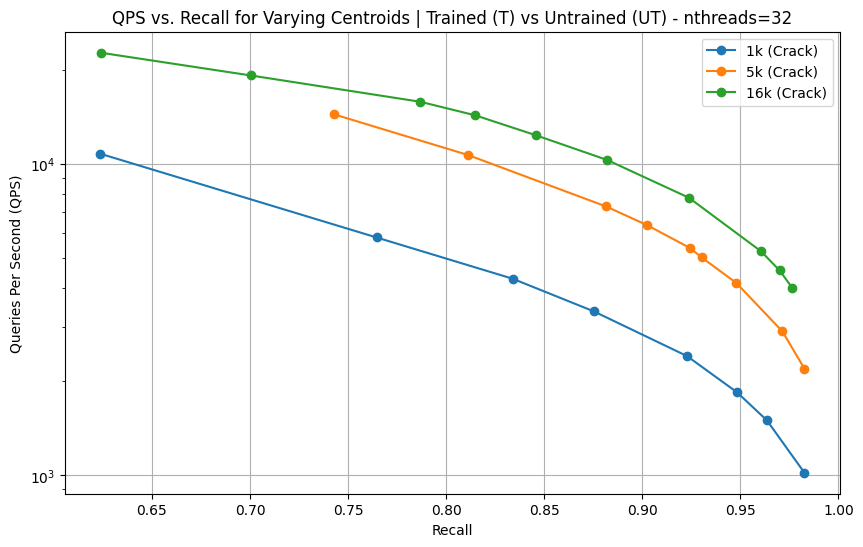

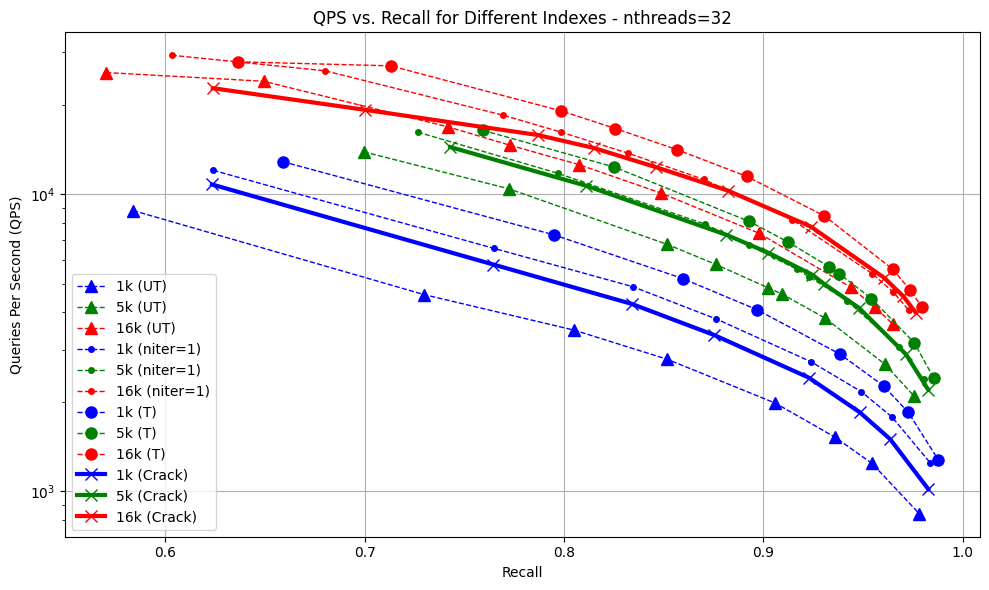

In [23]:
# results.extend(results_crack)
# Plot results (Recall vs QPS)
comb_results = results | results_crack


plt.figure(figsize=(10, 6))
for name, data in results_crack.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "^", # Cross for untrained
    "(niter=1)": ".",
    "(Crack)": "x",  # Use x for Crack
}

linestyle_styles = {
    "(T)": "--",      # Dashed line for trained
    "(UT)": "--",     # Dashed line for untrained
    "(niter=1)": "--",
    "(Crack)": "-",   # Solid line for Crack
    
}

# Line width for different statuses
line_widths = {
    "(T)": 1,    # Default width for trained
    "(UT)": 1,   # Default width for untrained
    "(niter=1)": 1,
    "(Crack)": 3,  # Make Crack line thicker to stand out
}

# Plot results
plt.figure(figsize=(10, 6))
comb_results = results | results_crack  # Combine results

for name, data in comb_results.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)", "(UT)", or "(Crack)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    linestyle = linestyle_styles[status]
    linewidth = line_widths[status]  # Set the line width based on the status
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    
    # Make the Crack line more prominent by adjusting its appearance
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle=linestyle, markersize=8, linewidth=linewidth)

# Title and labels
plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")

# Show grid, legend and plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# crack times during serach [ need to all add the .add() time at the start... ]
total_build_time = {}
for k,v in build_times_crack.items():
    total_build_time[k] = sum(v)
    print(k, total_build_time[k])

('1k (Crack)', 5) 2.5069857649796177
('1k (Crack)', 10) 2.5538868259318406
('1k (Crack)', 15) 2.516895634958928
('1k (Crack)', 20) 2.5976327489697724
('1k (Crack)', 30) 2.5830911690209177
('1k (Crack)', 40) 2.5855151059513446
('1k (Crack)', 50) 2.610251544014318
('1k (Crack)', 75) 2.5770153159755864
('5k (Crack)', 20) 9.095301779947476
('5k (Crack)', 30) 9.059714589151554
('5k (Crack)', 50) 9.098543186060851
('5k (Crack)', 60) 8.972590617071546
('5k (Crack)', 75) 9.035709255018446
('5k (Crack)', 80) 9.049614966956142
('5k (Crack)', 100) 9.053668405969802
('5k (Crack)', 150) 9.016333189036231
('5k (Crack)', 200) 9.101268274076574
('16k (Crack)', 20) 19.49763775199972
('16k (Crack)', 30) 18.71606282402354
('16k (Crack)', 50) 19.39226383796631
('16k (Crack)', 60) 19.550968751995242
('16k (Crack)', 75) 19.585529591051454
('16k (Crack)', 100) 19.371452035033144
('16k (Crack)', 150) 18.759462026151596
('16k (Crack)', 250) 18.72657454902219
('16k (Crack)', 300) 18.62777828690014
('16k (Crack)

In [27]:
index_labels

['1k', '5k', '16k']

In [31]:
total_build_time['1k (Crack)', 20]

2.5976327489697724

In [30]:
train_time_1000_niter_1

0.5001436120001017

In [32]:
add_time_1000_niter_1

1.7549815629972727

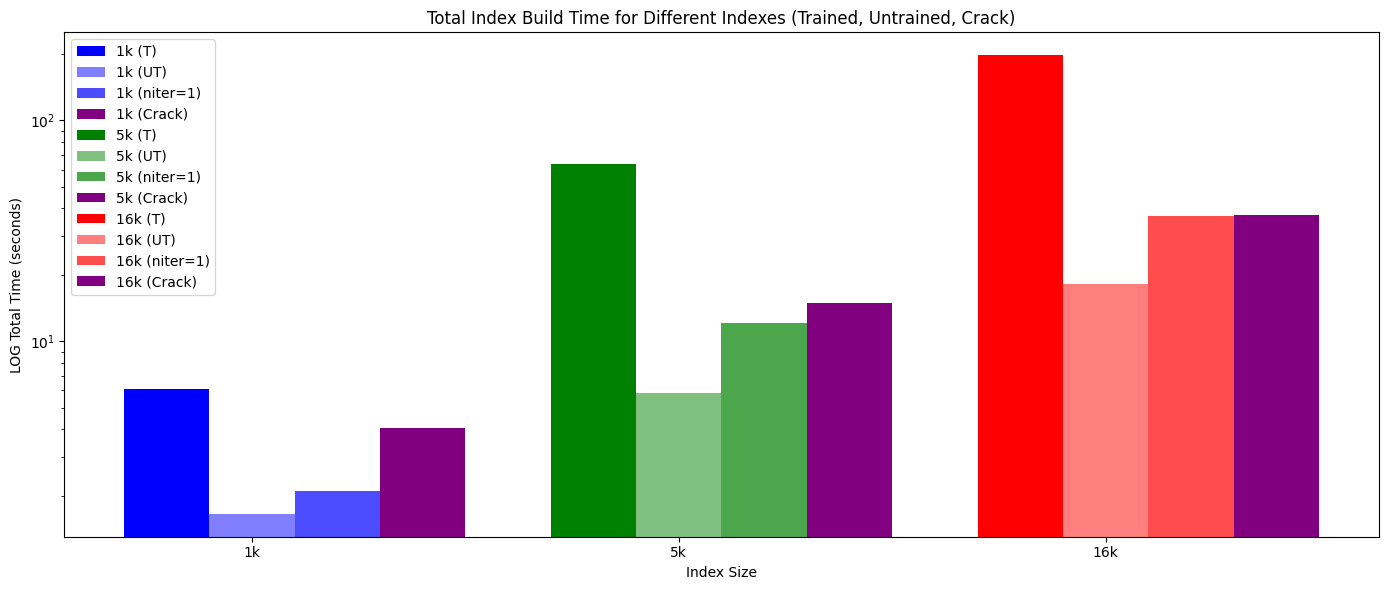

In [54]:
import matplotlib.pyplot as plt

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Store the results for training and adding times
train_times = {
    # trained
    "1k (T)": train_time_1000,
    "5k (T)": train_time_5000,
    "16k (T)": train_time_16000,
    # untrained
    "1k (UT)": train_time_1000_untrained,
    "5k (UT)": train_time_5000_untrained,
    "16k (UT)": train_time_16000_untrained,
    
    # niter=1
    "1k (niter=1)": train_time_1000_niter_1,
    "5k (niter=1)": train_time_5000_niter_1,
    "16k (niter=1)": train_time_16000_niter_1,

    # CRACK
    "1k (Crack)": total_build_time['1k (Crack)', 20],
    "5k (Crack)": total_build_time['5k (Crack)', 20],
    "16k (Crack)": total_build_time['16k (Crack)', 20],
}

add_times = {
    # trained
    "1k (T)": add_time_1000,
    "5k (T)": add_time_5000,
    "16k (T)": add_time_16000,
    
    # untrained
    "1k (UT)": add_time_1000_untrained,
    "5k (UT)": add_time_5000_untrained,
    "16k (UT)": add_time_16000_untrained,

    # niter=1
    "1k (niter=1)": add_time_1000_niter_1,
    "5k (niter=1)": add_time_5000_niter_1,
    "16k (niter=1)": add_time_16000_niter_1,

    # ADD same as untrained (same as trained), because we have same starting point
    "1k (Crack)": add_time_1000_untrained,
    "5k (Crack)": add_time_5000_untrained,
    "16k (Crack)": add_time_16000_untrained,
}
# Create lists for plotting
index_labels = ["1k", "5k", "16k"]
total_times_trained = []
total_times_untrained = []
total_times_crack = []
total_times_niter_1 = []

# Collect train and add times for plotting
# Collect train, add, and crack times for plotting
for label in index_labels:
    # Trained
    total_times_trained.append(train_times[f"{label} (T)"] + add_times[f"{label} (T)"])
    # Untrained
    total_times_untrained.append(train_times[f"{label} (UT)"] + add_times[f"{label} (UT)"])
    # Crack
    total_times_crack.append(train_times[f"{label} (Crack)"] + add_times[f"{label} (Crack)"])
    # niter = 1
    total_times_niter_1.append(train_times[f"{label} (niter=1)"] + add_times[f"{label} (niter=1)"])

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))

# Bar width and positions
bar_width = 0.2 # Adjust for three bars
index_pos = range(len(index_labels))

# Plotting bars
for i, label in enumerate(index_labels):
    # Trained bar
    ax.bar(index_pos[i] - bar_width, total_times_trained[i], bar_width, label=f'{label} (T)', color=index_colors[label])  
    # Untrained bar
    ax.bar(index_pos[i], total_times_untrained[i], bar_width, label=f'{label} (UT)', color=index_colors[label], alpha=0.5)  
    # niter = 1 bar
    ax.bar(index_pos[i] + bar_width, total_times_niter_1[i], bar_width, label=f'{label} (niter=1)', color=index_colors[label], alpha=0.7)  
    # Crack bar
    ax.bar(index_pos[i] + 2* bar_width, total_times_crack[i], bar_width, label=f'{label} (Crack)', color="purple", alpha=1)  

# Labels and title
ax.set_xlabel('Index Size')
ax.set_ylabel('LOG Total Time (seconds)')
ax.set_title('Total Index Build Time for Different Indexes (Trained, Untrained, Crack)')
ax.set_xticks(index_pos)
ax.set_xticklabels(index_labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.yscale("log")
plt.show()

Do the same with the skewed data...

In [39]:
_, xq, gt, _ = get_skewed_dataset(xb, 
                                skew_on_centroid=0, 
                                nlist=1000, 
                                compute_GT = True, 
                                nearest_cents_to_include=3,
                                seed=42,
                                print_skew=True,
                                plt_skew_nprobe=20,
                                )
xq.shape
desired_limit_queries= 10_000
factor = int(desired_limit_queries / xq.shape[0]) + 1 # duplicate until you have more than target num queires
print(f"{factor=}")
xq, gt = increase_queries_by_duplicates(xq, gt, factor)

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
- Total number of unique centroids visited: 382
- % of total centroids: 38.0 %
factor=3


- Total number of unique centroids visited: 380
- % of total centroids: 38.0 %


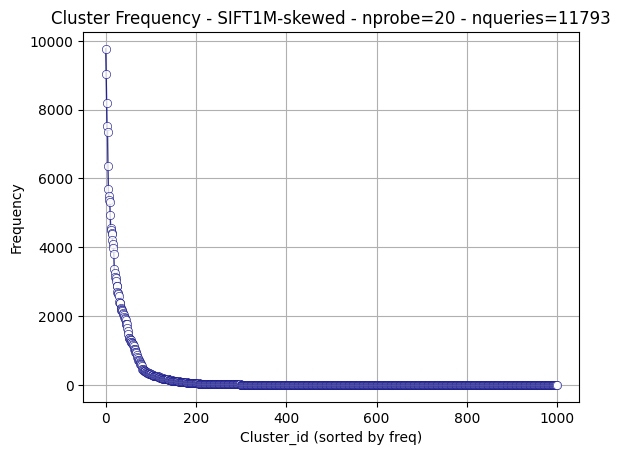

In [40]:
_ = get_centroid_ids_per_query(
        index=index_1000, # D(x)
        # combined_index, # D(x), Q(x) 
        queries=xq,
        nprobe=20,
        plot_hist=True,
        sorted_order=True,
        dataset_name = "SIFT1M-skewed"
)

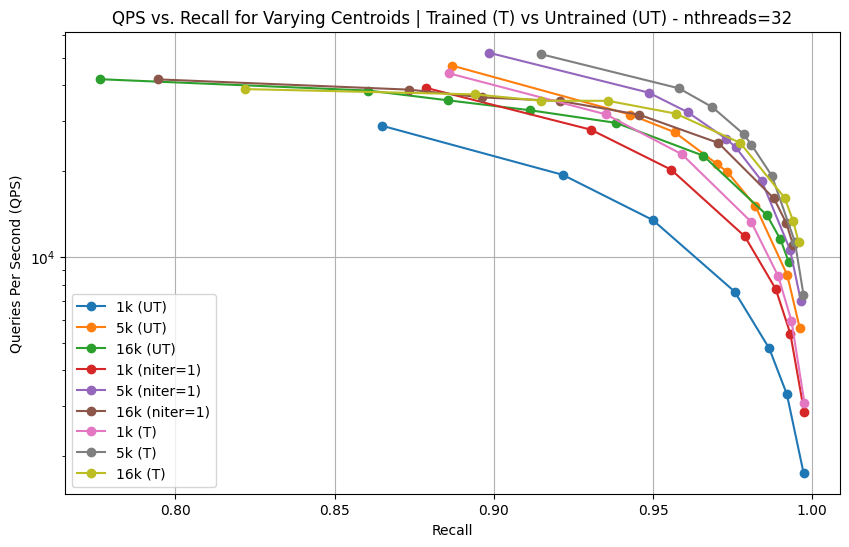

In [41]:
import numpy as np
import time
import matplotlib.pyplot as plt

batch_size = nthreads
topK = 100
nq, d = xq.shape
# I1 = np.empty((nq, topK), dtype="int32")
# D1 = np.empty((nq, topK), dtype="float32")
# I2 = np.empty((nq, topK), dtype="int32")
# D2 = np.empty((nq, topK), dtype="float32")
# I3 = np.empty((nq, topK), dtype="int32")
# D3 = np.empty((nq, topK), dtype="float32")

# Define independent nprobe values for each index
nprobe_values_1000 = [10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (UT)": (index_1000_untrained, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (UT)": (index_5000_untrained, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (UT)": (index_16000_untrained, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),


    "1k (niter=1)": (index_1000_niter_1, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (niter=1)": (index_5000_niter_1, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (niter=1)": (index_16000_niter_1, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),

    
    "1k (T)": (index_1000, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (T)": (index_5000, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (T)": (index_16000, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results_skewed = {key: [] for key in indexes.keys()}
batch_num = 0
limit_crack = limit_refine = 100
# Iterate over indexes and their independent nprobe values
for name, (index, nprobe_values, I, D) in indexes.items():
    for nprobe in nprobe_values:
        index.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        nq, topK = xq.shape[0], 100
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
                CRACK = REFINE = True
            else:
                CRACK = REFINE = False

            Di, Ii = index.search(xq[i0:i1], k=topK)
            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(t_batch_end - t_batch_start)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)
        qps = nq / total_time
        recall = compute_recall(I, gt, k=topK)
        results_skewed[name].append((qps, recall))

# Plot results_skewed (Recall vs QPS)
plt.figure(figsize=(10, 6))
for name, data in results_skewed.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

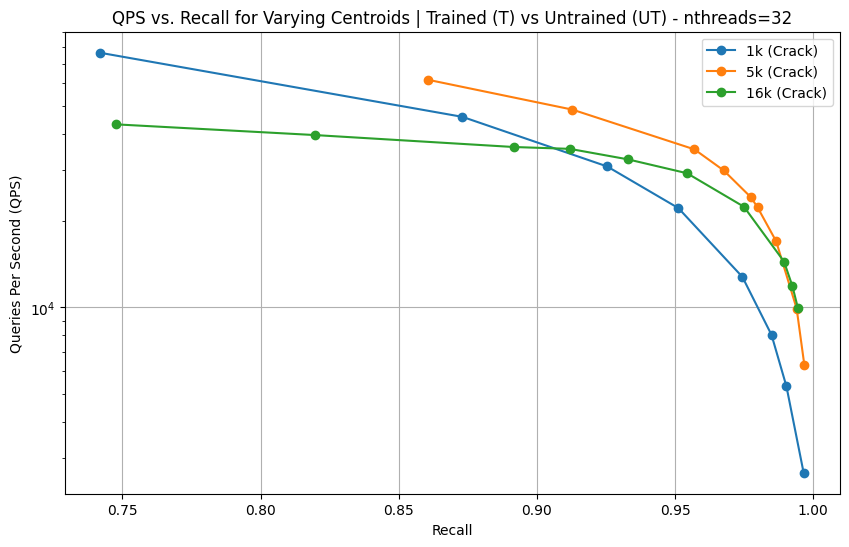

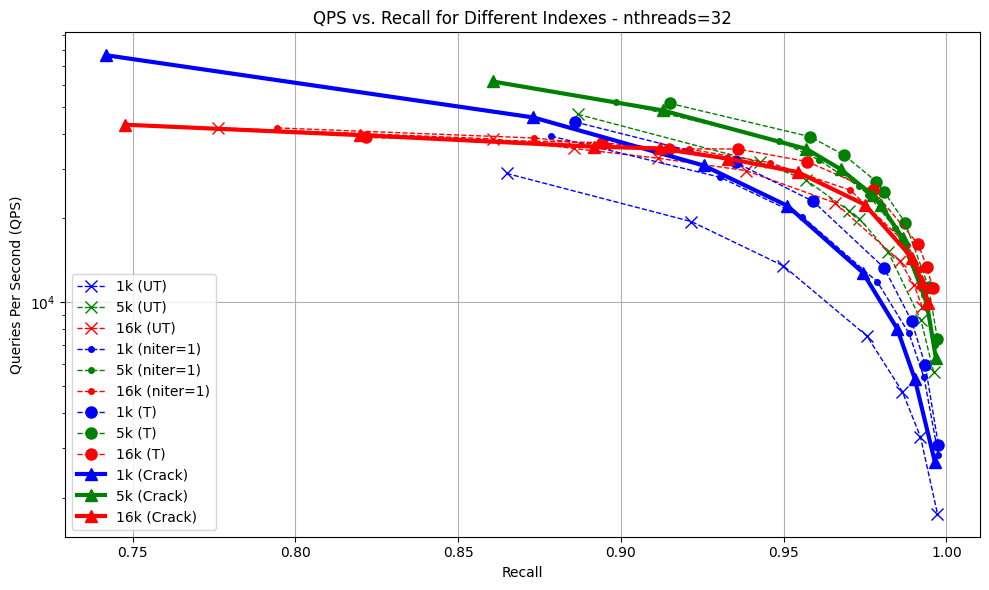

In [ ]:
# Cracking:
nlist = 1000
index_1000_crack, train_time_1000_crack, add_time_1000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 5000
index_5000_crack, train_time_5000_crack, add_time_5000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)
nlist = 16000
index_16000_crack, train_time_16000_crack, add_time_16000_crack = train_ivfflat(
    xb,
    nlist=nlist,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric=metric,
)

########################################

batch_size = nthreads
topK = 100
nq, d = xq.shape

# # Define independent nprobe values for each index
nprobe_values_1000 = [5, 10, 15, 20, 30, 40, 50, 75]
nprobe_values_5000 = [20, 30, 50, 60, 75, 80, 100, 150, 200]
nprobe_values_16000 = [20, 30, 50, 60, 75, 100, 150, 250, 300, 350]

# Map indexes to their nprobe values
indexes = {
    "1k (Crack)": (index_1000_crack, nprobe_values_1000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "5k (Crack)": (index_5000_crack, nprobe_values_5000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
    "16k (Crack)": (index_16000_crack, nprobe_values_16000, np.empty((nq, topK), dtype="int32"), np.empty((nq, topK), dtype="float32")),
}

results_crack_skew = {key: [] for key in indexes.keys()}

# Iterate over indexes and their independent nprobe values

build_times_crack_skew = defaultdict(list)

for name, (index, nprobe_values, I, D) in indexes.items():

    if "1k" in name:
        refine_nprobe = 50
        limit_crack = limit_refine = 10
    elif "5k" in name:
        refine_nprobe = 500
        limit_crack = limit_refine = 10
    elif "16k" in name:
        refine_nprobe = 1000
        limit_crack = limit_refine = 10

    for nprobe in nprobe_values:
        index_to_crack = faiss.clone_index(index) # reset to start each time
        _ = init_centroids_after_assignments(index_to_crack, metric=metric) # init cents

        index_to_crack.nprobe = nprobe
        timings = []  # Clear timings for each nprobe value
        i0 = 0
        batch_num = 0
        
        # Query the index
        while i0 < nq:
            t_batch_start = time.perf_counter()
            i1 = min(i0 + batch_size, nq)

            # if batch_num % 10 == 0 and i0 < limit_crack and i0 < limit_refine: 
            if batch_num <= limit_crack and batch_num <= limit_refine: 
                CRACK = REFINE = True
            else:
                CRACK = REFINE = False
            # dynamic_nprobe = min(nprobe, index.nlist)
            index_to_crack, Di, Ii, detailed_timings, d_nprobe = search_crack_refine_single(
                index_to_crack,
                xq[i0:i1],
                nprobe=nprobe,
                k=topK,
                refine_niter=1,
                CRACK=CRACK,
                REFINE=REFINE,
                # refine_nprobe_factor=None,
                metric=metric,
                refine_nprobe=refine_nprobe,
            )

            I[i0:i1], D[i0:i1] = Ii, Di
            t_batch_end = time.perf_counter()
            timings.append(detailed_timings["search"][0])
            
            # total time of build from individual operations
            total_time = 0
            for key in ["get_c_visited", "get_p_visited", "crack", "update_invlists", "replace_quantizer", "inner_point_assignments", "inner_km_train"]:
                # Safely check if the list is empty before accessing the first element
                timings_list = detailed_timings.get(key, [])
                if timings_list:
                    total_time += timings_list[0]  # Add the first element of the list
                else:
                    total_time += 0  # Default to 0 if the list is empty or not found
                
            build_times_crack_skew[(name, nprobe)].append(total_time)
            i0 = i1
            batch_num += 1
        
        # Compute QPS and Recall
        total_time = sum(timings)
        qps = nq / total_time
        recall = compute_recall(I, gt, k=topK)
        results_crack_skew[name].append((qps, recall))

# results.extend(results_crack)
# Plot results (Recall vs QPS)
comb_results_skew = results_skewed | results_crack_skew
plt.figure(figsize=(10, 6))
for name, data in results_crack_skew.items():
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    plt.plot(recall, qps, marker='o', label=name)

plt.title(f"QPS vs. Recall for Varying Centroids | Trained (T) vs Untrained (UT) - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Define marker styles for trained and untrained indexes
marker_styles = {
    "(T)": "o",  # Circle for trained
    "(UT)": "x", # Cross for untrained
    "(niter=1)": ".",
    "(Crack)": "^",
}

linestyle_styles = {
    "(T)": "--",      # Solid line for trained
    "(UT)": "--",    # Dashed line for untrained
    "(niter=1)": "--",
    "(Crack)": "-", # Dash-dot line for Crack
}

# Line width for different statuses
line_widths = {
    "(T)": 1,    # Default width for trained
    "(UT)": 1,   # Default width for untrained
    "(niter=1)": 1,
    "(Crack)": 3,  # Make Crack line thicker to stand out
}


# Plot results
plt.figure(figsize=(10, 6))
comb_results_skew = results_skewed | results_crack_skew

for name, data in comb_results_skew.items():
    # Determine base size and training status from the name
    base_size = name.split()[0]  # "1k", "5k", or "16k"
    status = name.split()[1]     # "(T)", "(UT)", or "(Crack)"
    
    color = index_colors[base_size]
    marker = marker_styles[status]
    linestyle = linestyle_styles[status]
    linewidth = line_widths[status]  # Set the line width based on the status
    
    # Extract data and plot
    data = np.array(data)
    recall, qps = data[:, 1], data[:, 0]
    
    # Make the Crack line more prominent by adjusting its appearance
    plt.plot(recall, qps, marker=marker, color=color, label=name, linestyle=linestyle, markersize=8, linewidth=linewidth)

# Title and labels
plt.title(f"QPS vs. Recall for Different Indexes - {nthreads=}")
plt.xlabel("Recall")
plt.ylabel("Queries Per Second (QPS)")
plt.yscale("log")

# Show grid, legend and plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
# crack times during serach [ need to all add the .add() time at the start... ]
total_build_time_skew = {}
for k,v in build_times_crack_skew.items():
    total_build_time_skew[k] = sum(v)
    print(k, total_build_time_skew[k])

('1k (Crack)', 5) 0.40788099194469396
('1k (Crack)', 10) 0.40550545703445096
('1k (Crack)', 15) 0.4101921609908459
('1k (Crack)', 20) 0.4152916849925532
('1k (Crack)', 30) 0.42017371598194586
('1k (Crack)', 40) 0.4122793879796518
('1k (Crack)', 50) 0.41819063500588527
('1k (Crack)', 75) 0.6923948299809126
('5k (Crack)', 20) 2.356698874042195
('5k (Crack)', 30) 2.256428494998545
('5k (Crack)', 50) 2.35436966503039
('5k (Crack)', 60) 2.415056278980046
('5k (Crack)', 75) 2.3686063370041666
('5k (Crack)', 80) 2.3600574519950897
('5k (Crack)', 100) 2.346180283013382
('5k (Crack)', 150) 2.350487267052813
('5k (Crack)', 200) 2.3486166449729353
('16k (Crack)', 20) 2.543961931980448
('16k (Crack)', 30) 2.5586233789872495
('16k (Crack)', 50) 2.5712131779946503
('16k (Crack)', 60) 2.561626795984921
('16k (Crack)', 75) 2.6314999170135707
('16k (Crack)', 100) 2.6377195900058723
('16k (Crack)', 150) 2.5394345000604517
('16k (Crack)', 250) 2.55172782002046
('16k (Crack)', 300) 2.5125935950054554
('16

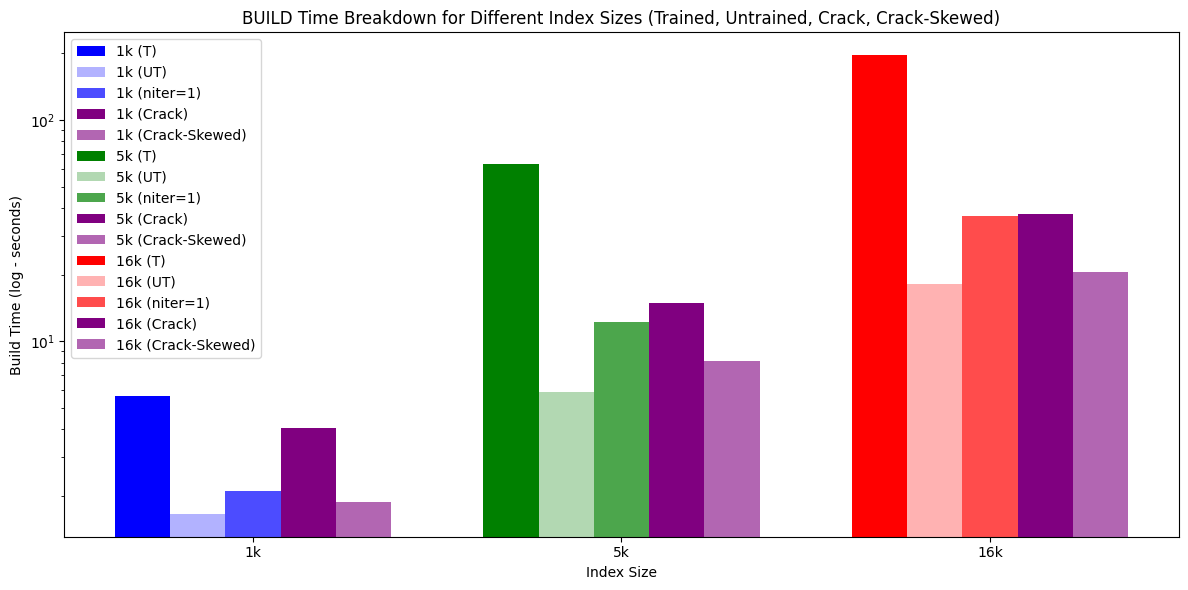

In [53]:
import matplotlib.pyplot as plt

# Define colors for each base index size
index_colors = {
    "1k": "blue",
    "5k": "green",
    "16k": "red"
}

# Store the results for training and adding times
train_times = {
    # trained
    "1k (T)": train_time_1000,
    "5k (T)": train_time_5000,
    "16k (T)": train_time_16000,
    # untrained
    "1k (UT)": train_time_1000_untrained,
    "5k (UT)": train_time_5000_untrained,
    "16k (UT)": train_time_16000_untrained,

    # niter=1
    "1k (niter=1)": train_time_1000_niter_1,
    "5k (niter=1)": train_time_5000_niter_1,
    "16k (niter=1)": train_time_16000_niter_1,
    
    # CRACK
    "1k (Crack)": total_build_time['1k (Crack)', 20],
    "5k (Crack)": total_build_time['5k (Crack)', 20],
    "16k (Crack)": total_build_time['16k (Crack)', 20],

    # Crack Skewed
    "1k (Crack-Skewed)": total_build_time_skew['1k (Crack)', 20],
    "5k (Crack-Skewed)": total_build_time_skew['5k (Crack)', 20],
    "16k (Crack-Skewed)": total_build_time_skew['16k (Crack)', 20],
}

add_times = {
    # Keep add the same everywhere for simplicity... to avoid cold starts variation
    # trained
    "1k (T)": add_time_1000_untrained,
    "5k (T)": add_time_5000_untrained,
    "16k (T)": add_time_16000_untrained,
    # untrained
    "1k (UT)": add_time_1000_untrained,
    "5k (UT)": add_time_5000_untrained,
    "16k (UT)": add_time_16000_untrained,

    # niter=1
    "1k (niter=1)": add_time_1000_niter_1,
    "5k (niter=1)": add_time_5000_niter_1,
    "16k (niter=1)": add_time_16000_niter_1,

    # ADD same as untrained (same as trained), because we have same starting point
    "1k (Crack)": add_time_1000_untrained,
    "5k (Crack)": add_time_5000_untrained,
    "16k (Crack)": add_time_16000_untrained,
    # ADD is same again... ( slight variation but keep it same for simplicity)
    "1k (Crack-Skewed)": add_time_1000_untrained,
    "5k (Crack-Skewed)": add_time_5000_untrained,
    "16k (Crack-Skewed)": add_time_16000_untrained,
}

# Create lists for plotting
index_labels = ["1k", "5k", "16k"]
total_times_trained = []
total_times_untrained = []
total_times_crack = []
total_times_crack_skewed = []
total_times_niter_1 = []

# Collect train, add, and crack times for plotting
for label in index_labels:
    # Trained
    total_times_trained.append(train_times[f"{label} (T)"] + add_times[f"{label} (T)"])
    # Untrained
    total_times_untrained.append(train_times[f"{label} (UT)"] + add_times[f"{label} (UT)"])
    # niter = 1
    total_times_niter_1.append(train_times[f"{label} (niter=1)"] + add_times[f"{label} (niter=1)"])

    # Crack
    total_times_crack.append(train_times[f"{label} (Crack)"] + add_times[f"{label} (Crack)"])
    # Crack Skewed
    total_times_crack_skewed.append(train_times[f"{label} (Crack-Skewed)"] + add_times[f"{label} (Crack-Skewed)"])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and positions
bar_width = 0.15  # Adjusted for five bars
index_pos = range(len(index_labels))

# Plotting bars
for i, label in enumerate(index_labels):
    # Trained bar
    ax.bar(index_pos[i] - 2 * bar_width, total_times_trained[i], bar_width, label=f'{label} (T)', color=index_colors[label])  
    # Untrained bar
    ax.bar(index_pos[i] - bar_width, total_times_untrained[i], bar_width, label=f'{label} (UT)', color=index_colors[label], alpha=0.3)  
    # niter = 1 bar
    ax.bar(index_pos[i], total_times_niter_1[i], bar_width, label=f'{label} (niter=1)', color=index_colors[label], alpha=0.7)  
    # Crack bar
    ax.bar(index_pos[i] + bar_width, total_times_crack[i], bar_width, label=f'{label} (Crack)', color="purple", alpha=1)  
    # Crack Skewed bar (different shade of purple)
    ax.bar(index_pos[i] + 2 * bar_width, total_times_crack_skewed[i], bar_width, label=f'{label} (Crack-Skewed)', color="purple", alpha=0.6)  

# Labels and title
ax.set_xlabel('Index Size')
ax.set_ylabel('Build Time (log - seconds)')
ax.set_title('BUILD Time Breakdown for Different Index Sizes (Trained, Untrained, Crack, Crack-Skewed)')
ax.set_xticks(index_pos)
ax.set_xticklabels(index_labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.yscale("log")
plt.show()